<a href="https://colab.research.google.com/github/MateoOrtiz001/Laboratory-LSTM-GRU-Inflation/blob/main/Laboratorio_LSTM_GRU_Inflacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratorio LSTM-GRU

En el presente cuaderno construirás dos redes neuronales recurrentes, una LSTM (memoria larga a corto plazo) y una GRU (unidad recurrente cerrada). Aplicando ambos modelos al modelamiento y predicción de la inflación en Colombia. Las LSTM fueron introducidas por [Hochreiter & Schmidhuber](https://direct.mit.edu/neco/article-abstract/9/8/1735/6109/Long-Short-Term-Memory) con el objetivo de mitigar el problema del desvanecimiento de gradientes en redes neuronales recurrentes, mientras que las GRU fueron introducidas por [Cho et al.](https://arxiv.org/pdf/1412.3555) como una versión simplificada de la memoria larga a corto plazo.

**Al finalizar este laboratorio serás capaz de:**
- Implementar estados ocultos de arquitecturas LSTM y GRU utilizando Numpy y Keras.
- Implementar dos modelos completos recurrentes para la predicción de series de tiempo.
- Entender el funcionamiento y el potencial de las redes neuronales recurrentes aplicado a problemas económicos, financieros y actuariales.

Para este laboratorio utilizarás Keras y Numpy.

Antes de ver el problema, corre la celda de abajo para cargar las librerias requeridas y los archivos auxiliares desde el [repositorio](https://github.com/MateoOrtiz001/Laboratory-LSTM-GRU-Inflation).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
!git clone https://github.com/MateoOrtiz001/Laboratory-LSTM-GRU-Inflation
sys.path.append('Laboratory-LSTM-GRU-Inflation')
from utils import *
from tester import *

Cloning into 'Laboratory-LSTM-GRU-Inflation'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 75 (delta 34), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (75/75), 1.90 MiB | 7.77 MiB/s, done.
Resolving deltas: 100% (34/34), done.


## Tabla de Contenido
- [1 - Dataset](#1)
- [2 - Problemas de gradientes en redes neuronales recurrentes](#2)
- [3 - Construyendo una LSTM](#3)
  - [3.1 - Construyendo el forward pass de una celda](#3-1)
  - [3.2 - Construyendo el forward pass del modelo](#3-2)
  - [3.3 - Construyendo la retropropagación de una celda](#3-3)
  - [3.4 - Construyendo la repropropagación del modelo](#3-4)
  - [3.5 - Entrenamiento del modelo](#3-5)
  - [3.6 - Predicción del modelo](#3-6)
- [4 - Construyendo una GRU](#4)
  - [4.1 - Construyendo el forward pass de una celda](#4-1)
  - [4.2 - Construyendo el forward pass del modelo](#4-2)
  - [4.3 - Construyendo la retropropagación de una celda](#4-3)
  - [4.4 - Construyendo la repropropagación del modelo](#4-4)
  - [4.5 - Entrenamiento del modelo](#4-5)
  - [4.6 - Predicción del modelo](#4-6)
- [5 - Implementaciones con Keras](#5)
- [6 - Predicciones con intervalos de confianza (Opcional)](#6)
- [7 - Bibliografía](#7)

<a name="1"></a>
## Dataset
El dataset seleccionado corresponde al histórico del indice mensual de la inflación en Colombia presentado por el banco de la república (disponible en su [base de datos](https://suameca.banrep.gov.co/buscador-de-series/#/)).

Primero vamos a cargar el dataset directamente desde el repositorio.

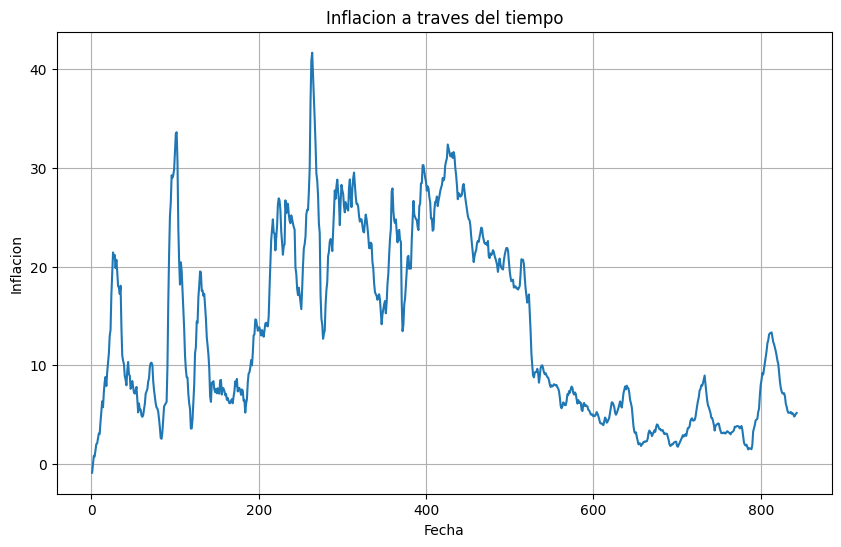

In [2]:
data = pd.read_excel('Laboratory-LSTM-GRU-Inflation/dataset/Datos-Inflacion.xlsx', decimal=',')

plt.figure(figsize=(10, 6))
plt.plot(data['Inflacion'])
plt.title('Inflacion a traves del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Inflacion')
plt.grid(True)
plt.show()

El conjunto de datos contiene el historial de inflación desde 1955. En primer lugar, recortaremos la información a partir del año 2000, ya que los patrones observados en los registros más antiguos difieren de los de las últimas dos décadas. Posteriormente, prepararemos las columnas para estandarizar los tipos de datos.

In [3]:
# Convertimos la columna 'Fecha' a objeto datetime y la seleccionamos como índice
data['Fecha'] = pd.to_datetime(data['Fecha'], format='%d/%m/%Y', errors='coerce')
data = data.dropna(subset=['Fecha']).set_index('Fecha')

# Eliminamos filas sin datos en la columna 'Inflacion'
data = data.dropna(subset=['Inflacion']).copy()

# Dividimos los datos de la inflacion sobre 100 para tener el porcentaje
data['Inflacion'] = pd.to_numeric(data['Inflacion'], errors='coerce') / 100

# Filtramos los datos desde 2000
data = data[data.index >= '2000-01-01']
display(data.head())

,Inflacion
Fecha,
2000-01-31,0.0825
2000-02-29,0.0889
2000-03-31,0.0973
2000-04-30,0.0996
2000-05-31,0.1000


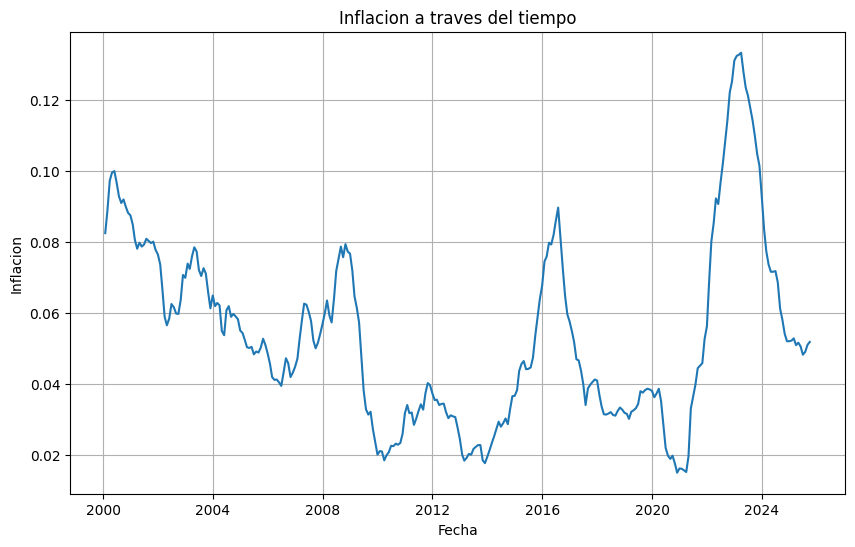

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(data['Inflacion'])
plt.title('Inflacion a traves del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Inflacion')
plt.grid(True)
plt.show()

Vamos a desarrollar modelos que tomen doce meses e intenten predecir el decimo tercer mes. Por ejemplo, para predecir la inflación a la fecha de diciembre de 2025 el modelo toma los meses de diciembre de 2024, enero, febreo, marzo, abril, mayo, junio, julio, agosto, septiembre, octubre y noviembre de 2025.

### Ejercicio 1 - Secuencia de ventanas
Para entrenar un modelo recurrente es necesario transformar la serie temporal en un conjunto de secuencias de entrada y salida.

Este proceso se conoce como **sliding window** o ventana deslizante, y consiste en recorrer los datos históricos con una ventana de longitud fija que captura una secuencia de valores pasados (entrada), asociándola con uno o varios valores futuros (salida).

Por ejemplo, si tenemos la siguiente serie temporal:

$$ [x_1,x_2,\dotsb, x_t  ]$$

y tenemos una ventana ```n_steps_in = 3``` para retornar un solo valor ```n_steps_out = 1```. Entonces las muestras de entrenamiento son de la forma:

* Entrada: $[x_1,x_2,x_3]$. Salida: $x_4$
* Entrada: $[x_2,x_3,x_4]$. Salida: $x_5$.
* Entrada: $[x_{i-1},x_i,x_{i+1}]$. Salida: $x_{i+2}$.

**Instrucciones**:
-  Fija el número de iteraciones para aplicar la serie deslizante.
-  Agrega al arreglo de las secuencias de entrada `X` los datos desde el instante actual `i` hasta el número de entradas `i + n_steps_in`.
-  Agrega al arreglo de valores objetivo `Y` los datos desde el número de entradas `i + n_steps_in` hasta el número de salidas `i + n_steps_in + n_steps_out`.

In [5]:
# Función calificadora: create_sequences

def create_sequences(data, n_steps_in, n_steps_out):
  """
  Crea secuencias de entrada-salida para RNN usando sliding window
  Argumentos:
  data -- array 1D con los datos de inflación
  n_steps_in -- número de pasos temporales de entrada (ventana)
  n_steps_out -- número de pasos a predecir (tamaño de la salida).

  Retorna:
  X -- array con secuencias de entrada, shape (n_samples, n_steps_in)
  Y -- array con valores objetivo, shape (n_samples, n_steps_out)
  """
  X, Y = [], []
  ### START CODE HERE ###
  # Recorremos la serie aplicando la ventana deslizante
  for i in range(len(data) - n_steps_in - n_steps_out + 1):
    # Secuencia de entrada: ventana de n_steps_in valores. X.append(...)
    X.append(data[i:(i + n_steps_in)])
    # Valor objetivo: el siguiente valor después de la ventana. Y.append(...)
    Y.append(data[i + n_steps_in:i + n_steps_in + n_steps_out])
  ### END CODE HERE ###

  return np.array(X), np.array(Y)

In [6]:
create_sequences_test(create_sequences)

Datos aleatorios generados:
[0.37454012 0.95071431 0.73199394 0.59865848 0.15601864 0.15599452
 0.05808361 0.86617615 0.60111501 0.70807258 0.02058449 0.96990985
 0.83244264 0.21233911 0.18182497 0.18340451 0.30424224 0.52475643
 0.43194502 0.29122914]

Primer secuencia de entrada (X):
[0.37454012 0.95071431 0.73199394 0.59865848 0.15601864]

Primer secuencia de salida (Y):
[0.15599452 0.05808361]
Test Aprobado


**Datos esperados:**

Primer secuencia de entrada (X):
```
[0.37454012 0.95071431 0.73199394 0.59865848 0.15601864]
```

Primer secuencia de salida (Y):
```
[0.15599452 0.05808361]
```

### Ejercicio 2 - Forma de los datos
La entrada ```x``` de los estados ocultos de nuestro modelo tienen la forma ```(n_x, m, T_x)```, que corresponde al número de neuronas, al número de muestras y a la longitud de la secuencia. Mientras que la salida ```y``` debe tener la forma ```(n_y,m,1)```, que corresponde al número de salidas, al tamaño de la muestra y a la única predicción que vamos a realizar.

**Instrucciones**:
-  Cambia la forma de los datos de entrada `X`y `Y` en las variables `X_reshaped` y `Y_reshaped`, respectivamente.

#### Pista:
-  Puede ser útil revisar la función ```reshape()``` en [NumPy](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html).


In [7]:
# Función calificadora: reshape_data

def reshape_data(X, Y):
  """
  Transforma datos al formato requerido para la LSTM y la red GRU.
  Los modelos esperan:
  - X: shape (n_x, m, T_x) donde:
    n_x = número de features
    m = batch size (número de muestras)
    T_x = longitud de secuencia temporal
  - Y: shape (n_y, m, 1) donde:
    n_y = número de salidas
    m = batch size

  Argumentos:
  X -- array shape (m, T_x)
  Y -- array shape (m, n_steps_out)

  Retorna:
  X_reshaped -- array shape (n_x, m, T_x)
  Y_reshaped -- array shape (n_y, m, 1)
  """
  ### START CODE HERE ###
  X_reshaped = X.reshape(1, X.shape[0], X.shape[1]) # X: de (m, T_x) a (1, m, T_x)
  Y_reshaped = Y.T.reshape(Y.shape[1], -1, 1)     # Y: de (m, n_steps_out) a (n_steps_out, m, 1)
  ### END CODE HERE ###

  return X_reshaped, Y_reshaped

In [8]:
reshape_data_test(reshape_data)

Probando con n_steps_in=10, n_steps_out=3, m=25
Shape inicial de X: (25, 10)
Reshape de X: (1, 25, 10)
Shape inicial de Y: (25, 3)
Reshape de Y: (3, 25, 1)
--------------------
Test Aprobado


### Preparación del conjunto de entrenamiento/prueba
Primero normalizamos los datos. Posteriormente creamos las secuencias con la función definida anteriormente.

In [9]:
# Utilizamos normalización con escala estándar
scaler = StandardScaler()
inflation_scaled = scaler.fit_transform(data[['Inflacion']].values)
# Configuración de ventana temporal
n_steps_in = 12  # Usar 12 meses previos para predecir el siguiente
n_steps_out = 1  # Predecir 1 mes adelante

X_seq, y_seq = create_sequences(inflation_scaled, n_steps_in, n_steps_out)

Ahora dividimos el conjunto de secuencias en 80% para entrenamiento y el 20% para prueba.
Además, para entrenar los modelos con Keras, necesitamos mantener la misma forma.

In [10]:
# Entrenamiento con el dataset
train_size = int(len(X_seq) * 0.8)  # 80% entrenamiento, 20% test

X_train_keras = X_seq[:train_size]
y_train_keras = y_seq[:train_size]
X_test_keras = X_seq[train_size:]
y_test_keras = y_seq[train_size:]

Finalmente cambiamos la forma de los datos para el entrenamiento para los modelos hechos en NumPy.

In [11]:
X_train, y_train = reshape_data(X_train_keras, y_train_keras)
X_test, y_test = reshape_data(X_test_keras, y_test_keras)

<a name="a"></a>
## Problemas de gradientes en redes neuronales recurrentes

Sabemos que una red neuronal recurrente se define como una composición de funciones no lineales, usualmente $\tanh$ y $\sigma$ como se observa en las siguientes ecuaciones.

$$ \hat{y} = \tanh \left(W_y h^{\langle t\rangle} + b_y  \right) $$
$$ h^{\langle t\rangle} = \sigma \left( W_h \left[h^{\langle t-1\rangle}; x^{\langle t\rangle}  \right] + b_h  \right) $$

Si en algún paso $h^{\langle t\rangle}$ los cómputos de la retropropagación se hacen muy pequeños entonces se corre el riesgo de propagar este error a través de la composición, esta propagación de error hace que en algún momento el valor de los parámetros convergan al $0$ numérico, matando las neuronas.

Para contrarrestar estos problemas numéricos, las arquitecturas LSTM y GRU operan los valores de los estados ocultos con *compuertas* que determinan los valores a propagar a través de la red.

<a name="3"></a>
## Primer Modelo: Construyendo una LSTM

La arquitectura de la celda LSTM puede verse en la siguiente Figura.
<center>
<img src="https://raw.githubusercontent.com/MateoOrtiz001/Laboratory-LSTM-GRU-Inflation/main/imagenes/LSTM01.png" width="500">
</center>
Se tienen tres compuertas $\Gamma_f$,$\Gamma_u$ y $\Gamma_o$, una célula de memoria para el estado $c^{\langle t\rangle}$ y un candidato a dicha célula $\tilde{c}^{\langle t\rangle}$.

-  *Compuerta de olvido* $\Gamma_f$: es un tensor que contiene valores entre $0$ y $1$.
    - Si una unidad en esta compuerta está muy cerca del 0 entonces la LSTM "olvidará" el estado guardado en la correspondiente unidad de la célula de memoria previa.
    - Si una unidad en esta compuerta está muy cerca del 1 entonces la LSTM recordará fuertemente su correspondiente valor guardado en la unidad de la célula de memoria.

    $$\Gamma_f = \sigma \left(W_f \left[h^{\langle t-1\rangle}; x^{\langle t\rangle}\right] + b_f\right)  \tag{1}$$

-  *Célula de memoria candidata* $\tilde{c}^{\langle t\rangle}$: es un tensor que contiene información del estado de tiempo actual que podría ser guardado en la célula de memoria actual $c^{\langle t\rangle}$.
    - Como los datos están normalizados, este tensor contiene valores entre $-1$ y $1$.

    $$\tilde{c}^{\langle t\rangle} = \tanh\left(W_c \left[h^{\langle t-1\rangle}; x^{\langle t\rangle}\right] + b_c\right) \tag{2} $$

-  *Compuerta de actualización* $\Gamma_u$: es un tensor que contiene valores entre $0$ y $1$.
    - Esta compuerta decide qué valores del candidato $\tilde{c}^{\langle t\rangle}$ son pasados a la célula de memoria $c^{\langle t\rangle}$. Las unidades cercanas al 0 no dejarán pasar valores, mientras que las más cercanas al 1 dejarán pasar fuertemente los valores.

    $$\Gamma_u = \sigma \left(W_u \left[h^{\langle t-1\rangle}; x^{\langle t\rangle}\right] + b_u\right)  \tag{3}$$

-  *Célula de memoria* $c^{\langle t\rangle}$: como su nombre indica, es la "memoria" que será pasada a estados ocultos posteriores.
    - Es simplemente la combinación entre la célula de memoria del estado anterior y el valor candidato.

    $$c^{\langle t\rangle} = \Gamma_f^{\langle t\rangle} * c^{\langle t-1\rangle} + \Gamma_u^{\langle t\rangle} * \tilde{c}^{\langle t\rangle} \tag{4}$$

-  *Compuerta de salida* $\Gamma_o$: es un tensor que contiene valores entre $0$ y $1$.
    - Esta compuerta decide qué enviar a la salida del estado oculto.

    $$\Gamma_o = \sigma \left(W_o \left[h^{\langle t-1\rangle}; x^{\langle t\rangle}\right] + b_o\right)  \tag{5}$$

-  *Estado oculto* $h^{\langle t\rangle}$: es un tensor que sirve como entrada para el siguiente paso de tiempo.
    - Es usado para determinar las compuertas del siguiente paso del tiempo.
    - Es simplemente la combinación entre la compuerta de salida $\Gamma_o$ y el estado de memoria $c\langle t\rangle$, este último sobre la función $\tanh$.
    - La compuerta actúa para determinar qué valores de la célula de memoria deben ser incluídos en el estado oculto actual.

    $$h^{\langle t\rangle} = \Gamma_o * \tanh\left(c^{\langle t\rangle}\right) \tag{6}$$

<a name="3-1"></a>
### Ejercicio 3 - Celda del Foward Pass
Implementa la celda LSTM observada en la Figura.

**Intrucciones**:
1. Concatena el estado oculto $h^{\langle t-1 \rangle}$ $x^{\langle t \rangle}$ en una sola matriz:  

$$concat = \begin{bmatrix} h^{\langle t-1 \rangle} \\ x^{\langle t \rangle} \end{bmatrix}$$  

2. Computa todas las fórmulas (1 hasta 6) para las compuertas, el estado oculto y el estado de la célula.
3. Para este problema, no tienes que computar la predicción $y^{\langle t \rangle}$ en todas las celdas, luego no deberás implementarla aquí.

#### Pistas
* Puedes usar [numpy.concatenate](https://docs.scipy.org/doc/numpy/reference/generated/numpy.concatenate.html).  Revisa qué valor usar para el parámetro `axis`.
* Las funciones `sigmoid()` y `softmax` se importan desde `utils.py`.
* La documentación sobre [numpy.tanh](https://docs.scipy.org/doc/numpy/reference/generated/numpy.tanh.html)
* Usa [numpy.dot](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html) para la multiplicación de matrices.

In [12]:
# Función adaptada del curso de deepLearningAi. Lab15a: Building a Recurrent Neuronal Network Step by Step
# Función calificadora: lstm_cell_forward

def lstm_cell_forward(xt, h_prev, c_prev, parameters):
    """
    Implementar un solo paso de la celda LSTM como se describe en la Figura (4)
    Argumentos:
    xt -- la entrada en el timestep "t", numpy array de forma (n_x, m)
    h_prev -- Estado oculto en el tiempo "t-1", numpy array de la forma (n_a,m)
    c_prev -- Celula de memoria en el tiempo "t-1", numpy array of shape (n_a, m)
    parametros -- diccionario de python que contiene:
                        Wf -- Matriz de pesos de la compuerta de olvido, numpy array de forma (n_h, n_h + n_x)
                        bf -- Sesgo de la compuerta de olvido, numpy array de forma (n_a, 1)
                        Wu -- Matriz de pesos de la compuerta de actualización, numpy array de forma (n_h, n_h + n_x)
                        bu -- Sesgo de la compuerta de actualización, numpy array de forma (n_a, 1)
                        Wc -- Matriz de pesos de la primera "tanh", numpy array de forma (n_h, n_h + n_x)
                        bc --  Sesgo de la primera "tanh", numpy array de forma (n_h, 1)
                        Wo -- Matriz de pesos de la compuerta de salida, numpy array de forma (n_h, n_h + n_x)
                        bo --  Sesgo de la compuerta de salida, numpy array de forma (n_h, 1)


    Returns:
    h_next -- siguiente estado oculto, de forma (n_a, m)
    c_next -- siguiente estado de memoria, de forma (n_a, m)
    cache -- tupla de valores necesarios para el paso hacia atrás, contiene (h_next, c_next, h_prev, c_prev, xt, parameters)

    Nota: ft/ut/ot significan las compuertas de olvido/actualización/salida, cct significa el valor candidato (c tilde),
          c significa el estado de la celda (memoria)
    """

    # Recuperar parámetros de "parameters"
    Wf = parameters["Wf"] # peso de la compuerta de olvido
    bf = parameters["bf"]
    Wu = parameters["Wu"] # peso de la compuerta de actualización (observar el nombre de la variable)
    bu = parameters["bu"] # (observar el nombre de la variable)
    Wc = parameters["Wc"] # peso del valor candidato
    bc = parameters["bc"]
    Wo = parameters["Wo"] # peso de la compuerta de salida
    bo = parameters["bo"]


    # Recuperar dimensiones de las formas de xt
    n_x, m = xt.shape
    n_a, _ = h_prev.shape # Asumiendo que la forma de h_prev es (n_a, m)

    ### START CODE HERE ###
    # Concatenar h_prev y xt
    concat = np.concatenate((h_prev,xt))

    # Calcular valores para ft, ut, cct, c_next, ot, h_next usando las fórmulas dadas en la figura (4)
    ft = sigmoid(np.dot(Wf,concat) + bf)
    ut = sigmoid(np.dot(Wu,concat) + bu)
    cct = np.tanh(np.dot(Wc,concat) + bc)
    c_next = ft * c_prev + ut * cct
    ot = sigmoid(np.dot(Wo,concat) + bo)
    h_next = ot * np.tanh(c_next)

    ### END CODE HERE ###

    # almacenar valores necesarios para la propagación hacia atrás en la caché
    cache = (h_next, c_next, h_prev, c_prev, ft, ut, cct, ot, xt, parameters)

    return h_next, c_next, cache

In [13]:
lstm_cell_forward_test(lstm_cell_forward)

Test Aprobado


<a name="3-2"></a>
### Ejercicio 4 - Forward Pass

Ya haz implementado un paso de una LSTM, ahora puedes iterar sobre toda la secuencia utilizando un bucle sobre todas las entradas $T_x$.

Implementa el modelo LSTM iterando las celdas hasta los $T_x$ pasos de tiempo.

**Intrucciones**:
-  Obtén las dimensiones $n_x,n_h,n_y,m,T_x$ de las formas de las variables `x`y `parameters`.
-  Inicializa los tensores 3D $h,c$ y $y$
    -  $h$: estado oculto, forma $(n_h,m,T_x)$.
    -  $c$: célula de memoria, forma $(n_h,m,T_x)$.
    -  $y$: predicción, forma $(n_h,m,T_y)$ donde $T_y=1$.
-  Inicializa el tensor 2D $h^{\langle t\rangle}$.
    -  $h^{\langle t\rangle}$ guarda el estado oculto para el paso de tiempo $t$. El nombre de la variable es `h_next`.
    -  $h^{\langle 0\rangle}$, el estado oculto en el tiempo $0$, se pasa cuando se llama la función. El nombre de la variable es `h0`.
    -  Inicializa $h^{\langle t\rangle}$ con el estado oculto $h^{\langle 0\rangle}$ que se pasa a la función.
-  Inicializa $c^{\langle t\rangle}$ con ceros.
    -  El nombre de la variable es `c_next`.
-  Para cada instante de tiempo, realiza lo siguiente
    -  Desde el tensor 3D $x$, toma la parte 2D $x^{\langle t\rangle}$ en el instante de tiempo $t$.
    -  Llama la función `lstm_cell_forward` definida anteriormente, para obtener el estado oculto, la célula de memoria y el cache.
    -  Guarda el estado oculto y la célula de memoria dentro de los tensores 3D.
    -  Agrega el cache a los caches.

*Nota*: En este caso observa que la predicción se retorna directamente como un tensor 2D.

In [14]:
# Función adaptada del curso de deepLearningAi. Lab15a: Building a Recurrent Neuronal Network Step by Step
# Función calificadora: lstm_forward

def lstm_forward(x, h0, parameters):
    """
    Implementa la propagación hacia adelante de la red neuronal recurrente usando una celda LSTM descrita en la Figura (4).

    Argumentos:
    x -- Datos de entrada para cada paso de tiempo, de forma (n_x, m, T_x).
    h0 -- Estado oculto inicial, de forma (n_h, m)
    parameters -- diccionario de python que contiene:
                        Wf -- Matriz de pesos de la compuerta de olvido, numpy array de forma (n_h, n_h + n_x)
                        bf -- Sesgo de la compuerta de olvido, numpy array de forma (n_h, 1)
                        Wu -- Matriz de pesos de la compuerta de actualización, numpy array de forma (n_h, n_h + n_x)
                        bu -- Sesgo de la compuerta de actualización, numpy array de forma (n_h, 1)
                        Wc -- Matriz de pesos de la primera "tanh", numpy array de forma (n_h, n_h + n_x)
                        bc -- Sesgo de la primera "tanh", numpy array de forma (n_h, 1)
                        Wo -- Matriz de pesos de la compuerta de salida, numpy array de forma (n_h, n_h + n_x)
                        bo -- Sesgo de la compuerta de salida, numpy array de forma (n_h, 1)
                        Wy -- Matriz de pesos que relaciona el estado oculto con la salida, numpy array de forma (n_y, n_h)
                        by -- Sesgo que relaciona el estado oculto con la salida, numpy array de forma (n_y, 1)

    Returns:
    h -- Estados ocultos para cada paso de tiempo, numpy array de forma (n_h, m, T_x)
    y -- Predicciones para cada paso de tiempo, numpy array de forma (n_y, m)
    c -- El valor del estado de la celda, numpy array de forma (n_h, m, T_x)
    caches -- tupla de valores necesarios para el paso hacia atrás, contiene (lista de todas las cachés, x)
    """

    # Inicializar "caches", que rastreará la lista de todas las cachés
    caches = []
    Wy = parameters['Wy']
    by = parameters['by']

    ### START CODE HERE ###
    # Recuperar dimensiones de las formas de x y parameters['Wy']
    n_x, m, T_x = x.shape
    n_y, n_h = Wy.shape

    # inicializar "h", "c" y "y" con ceros
    h = np.zeros((n_h,m,T_x))
    c = np.zeros((n_h,m,T_x))
    y = np.zeros((n_y,m,1))

    # Inicializar h_next y c_next
    h_next = h0
    c_next = np.zeros((n_h,m))

    # iterar sobre todos los pasos de tiempo
    for t in range(T_x): # Iterar a través de todos los pasos de tiempo
        # Obtener la sección 2D 'xt' de la entrada 3D 'x' en el paso de tiempo 't'
        xt = x[:,:,t]
        # Actualizar el siguiente estado oculto, el siguiente estado de memoria, calcular la predicción, obtener la caché
        h_next, c_next, cache = lstm_cell_forward(xt,h_next,c_next,parameters)

        # Guardar el valor del nuevo estado oculto "siguiente" en h
        h[:,:,t] = h_next
        # Guardar el valor del siguiente estado de celda
        c[:,:,t]  = c_next
        # Añadir la caché a caches
        caches.append(cache)
    ### END CODE HERE ###

    y = np.dot(Wy,h[:,:,-1]) + by

    # almacenar valores necesarios para la propagación hacia atrás en la caché
    caches = (caches, x)

    return h, y, c, caches

In [15]:
lstm_forward_test(lstm_forward)

Test Aprobado


<a name="3-3"></a>
### Ejercicio 5 - Celda del Backward Pass

Ya con la propagación hacia adelante programada, ahora podemos calcular le retropropagación hacia atrás para el entrenamiento del modelo.
<center>
<img src="https://raw.githubusercontent.com/MateoOrtiz001/Laboratory-LSTM-GRU-Inflation/main/imagenes/LSTM02.png" width="500">
</center>
En cada celda calculamos la derivada de las variables asociadas a los pesos y sesgos de las compuertas, y las derivadas de la entrada $x^{\langle t\rangle}$ y de los estados anteriores $h^{\langle t-1\rangle}$ y $c^{\langle t-1\rangle}$.

Como la retropropagación se hace hacia atrás de forma iterativa desde el instante $T_x$, en cada paso tenemos $dh^{\langle t\rangle}$ y $dc^{\langle t\rangle}$, llamados en el código `dh_next` y `dc_next` respectivamente. Con esto, las derivadas de cada compuerta está dada como sigue.

\begin{align}
do^{\langle t \rangle} &= dh^{\langle t \rangle}*\tanh(c^{\langle t\rangle}) * \Gamma_o^{\langle t \rangle}*\left(1-\Gamma_o^{\langle t \rangle}\right)\tag{1} \\[8pt]
d\widetilde{c}^{\langle t \rangle} &= \left(dc^{\langle t\rangle}*\Gamma_u^{\langle t \rangle}+ \Gamma_o^{\langle t \rangle}* (1-\tanh^2(c^{\langle t\rangle})) * \Gamma_u^{\langle t \rangle} * dh^{\langle t \rangle} \right) * \left(1-\left(\widetilde c^{\langle t \rangle}\right)^2\right) \tag{2} \\[8pt]
du^{\langle t \rangle} &= \left(dc^{\langle t\rangle}*\widetilde{c}^{\langle t \rangle} + \Gamma_o^{\langle t \rangle}* (1-\tanh^2(c^{\langle t\rangle})) * \widetilde{c}^{\langle t \rangle} * dh^{\langle t \rangle}\right)*\Gamma_u^{\langle t \rangle}*\left(1-\Gamma_u^{\langle t \rangle}\right)\tag{3} \\[8pt]
df^{\langle t \rangle} &= \left(dc^{\langle t\rangle}* c^{\langle t-1\rangle} + \Gamma_o^{\langle t \rangle} * (1-\tanh^2(c^{\langle t\rangle}) * c^{\langle t-1\rangle} * dh^{\langle t \rangle}\right)*\Gamma_f^{\langle t \rangle}*\left(1-\Gamma_f^{\langle t \rangle}\right)\tag{4}
\end{align}

Con esto podemos calcular las derivadas de los parámetros. Primero, la derivada de los pesos está dada como

$ dW_f = df^{\langle t \rangle} \begin{bmatrix} h^{\langle t-1\rangle} \\ x^{\langle t\rangle}\end{bmatrix}^T \tag{5} $
$ dW_u = du^{\langle t \rangle} \begin{bmatrix} h^{\langle t-1\rangle} \\ x^{\langle t\rangle}\end{bmatrix}^T \tag{6} $
$ dW_c = d\widetilde c^{\langle t \rangle} \begin{bmatrix} h^{\langle t-1\rangle} \\ x^{\langle t\rangle}\end{bmatrix}^T \tag{7} $
$ dW_o = do^{\langle t \rangle} \begin{bmatrix} h^{\langle t-1\rangle} \\ x^{\langle t\rangle}\end{bmatrix}^T \tag{8}$

Para calcular los sesgos $db_f, db_u, db_c, db_o$ solo necesitas sumar a través de todas las 'm' muestras (axis= 1) de $df^{\langle t \rangle}, du_u^{\langle t \rangle}, d\widetilde c^{\langle t \rangle}, d_o^{\langle t \rangle}$ respectivamente. Observa que tienes que tener `keepdims = True`.

$\displaystyle db_f = \sum_{batch}df^{\langle t \rangle}\tag{9}$
$\displaystyle db_u = \sum_{batch}du^{\langle t \rangle}\tag{10}$
$\displaystyle db_c = \sum_{batch}dc^{\langle t \rangle}\tag{11}$
$\displaystyle db_o = \sum_{batch}do^{\langle t \rangle}\tag{12}$

Finalmente, debes calcular la derivada con respeceto al estado anterior, la célula de memoria anterior y la salida.
$ dh^{\langle t-1\rangle} = W_f^T df^{\langle t \rangle} + W_u^T   du^{\langle t \rangle}+ W_c^T d\widetilde c^{\langle t \rangle} + W_o^T do^{\langle t \rangle} \tag{13}$

Aquí, para referirnos a la concatenación de los pesos para la ecuación (13) son los primeros $n_h$ valores, es decir, $W_f = W_f[:,:n_h]$, etc.

$ dc^{\langle t-1\rangle} = dc^{\langle t\rangle}*\Gamma_f^{\langle t \rangle} + \Gamma_o^{\langle t \rangle} * (1- \tanh^2(c^{\langle t\rangle}))*\Gamma_f^{\langle t \rangle}*dh^{\langle t\rangle} \tag{14}$

$ dx^{\langle t \rangle} = W_f^T df^{\langle t \rangle} + W_u^T  du^{\langle t \rangle}+ W_c^T d\widetilde c^{\langle t \rangle} + W_o^T do^{\langle t \rangle}\tag{15} $

en donde los pesos para la ecuación (15) van desde $n_a$ hasta el final, es decir $W_f = W_f[:,n_a:]$, etc.

**Instrucciones:**
-  Implementa las ecuaciones (1) - (15) de arriba.
    - $do^{\langle t \rangle}$ es representado por  `dot`,    
    - $d\widetilde{c}^{\langle t \rangle}$ es representado por  `dcct`,  
    - $du^{\langle t \rangle}$ es representado por  `dot`,  
    - $df^{\langle t \rangle}$ es representado por `dft`.

In [16]:
# Función adaptada del curso de deepLearningAi. Lab15a: Building a Recurrent Neuronal Network Step by Step
# Función calificadora: lstm_cell_backward

def lstm_cell_backward(dh_next, dc_next, cache):
    """
    Implementa el paso hacia atrás para la celda LSTM (un solo paso de tiempo).

    Argumentos:
    dh_next -- Gradientes del siguiente estado oculto, de forma (n_a, m)
    dc_next -- Gradientes del siguiente estado de celda, de forma (n_a, m)
    cache -- caché que almacena información del paso hacia adelante

    Returns:
    gradients -- diccionario de python que contiene:
                        dxt -- Gradiente de los datos de entrada en el paso de tiempo t, de forma (n_x, m)
                        dh_prev -- Gradiente con respecto al estado oculto anterior, numpy array de forma (n_a, m)
                        dc_prev -- Gradiente con respecto al estado de memoria anterior, de forma (n_a, m, T_x)
                        dWf -- Gradiente con respecto a la matriz de pesos de la compuerta de olvido, numpy array de forma (n_a, n_a + n_x)
                        dWu -- Gradiente con respecto a la matriz de pesos de la compuerta de actualización, numpy array de forma (n_a, n_a + n_x)
                        dWc -- Gradiente con respecto a la matriz de pesos de la compuerta de memoria, numpy array de forma (n_a, n_a + n_x)
                        dWo -- Gradiente con respecto a la matriz de pesos de la compuerta de salida, numpy array de forma (n_a, n_a + n_x)
                        dbf -- Gradiente con respecto a los sesgos de la compuerta de olvido, de forma (n_a, 1)
                        dbu -- Gradiente con respecto a los sesgos de la compuerta de actualización, de forma (n_a, 1)
                        dbc -- Gradiente con respecto a los sesgos de la compuerta de memoria, de forma (n_a, 1)
                        dbo -- Gradiente con respecto a los sesgos de la compuerta de salida, de forma (n_a, 1)
    """

    # Recuperar información de "cache"
    (h_next, c_next, h_prev, c_prev, ft, ut, cct, ot, xt, parameters) = cache

    ### START CODE HERE ###
    # Recuperar dimensiones de las formas de xt y h_next
    n_x, m = xt.shape
    n_h, m = h_next.shape

    # Calcular derivadas relacionadas con las compuertas. Sus valores se pueden encontrar observando cuidadosamente las ecuaciones (1) a (4)
    dot = dh_next * np.tanh(c_next) * ot * (1 - ot)
    dcct = (dc_next * ut + ot * (1 - np.power(np.tanh(c_next),2)) * ut * dh_next) * (1 - np.power(cct,2))
    dut = (dc_next * cct + ot * (1 - np.power(np.tanh(c_next),2)) * cct * dh_next) * ut * (1 - ut)
    dft = (dc_next * c_prev + ot * (1 - np.power(np.tanh(c_next),2)) * c_prev * dh_next) * ft * (1 - ft)

    # Calcular derivadas relacionadas con los parámetros. Usar ecuaciones (11)-(18)
    concat_t = np.concatenate((h_prev,xt),axis=0).T
    dWf = np.dot(dft,concat_t)
    dWu = np.dot(dut,concat_t)
    dWc = np.dot(dcct,concat_t)
    dWo = np.dot(dot,concat_t)
    dbf = np.sum(dft,axis=1,keepdims=True)
    dbu = np.sum(dut,axis=1,keepdims=True)
    dbc = np.sum(dcct,axis=1,keepdims=True)
    dbo = np.sum(dot,axis=1,keepdims=True)

    # Calcular derivadas con respecto al estado oculto anterior, estado de memoria anterior y entrada. Usar ecuaciones (19)-(21).
    dh_prev = np.dot(parameters["Wf"][:,:n_h].T,dft) + np.dot(parameters["Wu"][:,:n_h].T,dut) + np.dot(parameters["Wc"][:,:n_h].T,dcct) + np.dot(parameters["Wo"][:,:n_h].T, dot)
    dc_prev = dc_next * ft + ot * (1- np.power(np.tanh(c_next),2)) * ft * dh_next
    dxt = np.dot(parameters["Wf"][:,n_h:].T,dft) + np.dot(parameters["Wu"][:,n_h:].T,dut) + np.dot(parameters["Wc"][:,n_h:].T,dcct) + np.dot(parameters["Wo"][:,n_h:].T, dot)
    ### END CODE HERE ###



    # Guardar gradientes en el diccionario
    gradients = {"dxt": dxt, "dh_prev": dh_prev, "dc_prev": dc_prev, "dWf": dWf,"dbf": dbf, "dWu": dWu,"dbu": dbu,
                "dWc": dWc,"dbc": dbc, "dWo": dWo,"dbo": dbo}

    return gradients

In [17]:
lstm_cell_backward_test(lstm_cell_backward,lstm_cell_forward)

Test Aprobado


<a name="3-4"></a>
### Ejercicio 6 - Backward Pass

Calcular los gradientes del costo con respecto a $h^{\langle t\rangle}$ en cada paso de tiempo $t$ es útil porque ayuda a retropropagar el gradiente a la celda LSTM anterior. Para hacerlo, tienes que iterar a través de todos los pasos de tiempo empezando por el final $T_x$, y en cada paso, incrementar las derivadas de los parámetros y guardar $dx$.

**Instrucciones**:
-  Crea un bucle empezando desde $T_x$ retrocediendo. Para cada paso, llama tu función `lst_cell_backward` y actualiza los antiguos gradientes sumando los nuevos gradientes.
    -  Observa que `dxt`no se actualiza, pero sí se guarda.

In [18]:
# Función adaptada del curso de deepLearningAi. Lab15a: Building a Recurrent Neuronal Network Step by Step
# Función calificadora: lstm_backward

def lstm_backward(dh, caches, m_batch):

    """
    Implementa el paso hacia atrás para la RNN con celda LSTM (sobre una secuencia completa).

    Argumentos:
    dh -- Gradientes con respecto a los estados ocultos, numpy-array de forma (n_h, m, T_x)
    caches -- caché que almacena información del paso hacia adelante (lstm_forward)
    m_batch -- El tamaño del minibatch, entero

    Returns:
    gradients -- diccionario de python que contiene:
                        dx -- Gradiente de las entradas, de forma (n_x, m, T_x)
                        dh0 -- Gradiente con respecto al estado oculto anterior, numpy array de forma (n_h, m)
                        dWf -- Gradiente con respecto a la matriz de pesos de la compuerta de olvido, numpy array de forma (n_h, n_h + n_x)
                        dWu -- Gradiente con respecto a la matriz de pesos de la compuerta de actualización, numpy array de forma (n_h, n_h + n_x)
                        dWc -- Gradiente con respecto a la matriz de pesos de la compuerta de memoria, numpy array de forma (n_h, n_h + n_x)
                        dWo -- Gradiente con respecto a la matriz de pesos de la compuerta de salida, numpy array de forma (n_h, n_h + n_x)
                        dbf -- Gradiente con respecto a los sesgos de la compuerta de olvido, de forma (n_h, 1)
                        dbu -- Gradiente con respecto a los sesgos de la compuerta de actualización, de forma (n_h, 1)
                        dbc -- Gradiente con respecto a los sesgos de la compuerta de memoria, de forma (n_h, 1)
                        dbo -- Gradiente con respecto a los sesgos de la compuerta de salida, de forma (n_h, 1)
    """

    # Recuperar valores de la primera caché de caches.
    (caches, x) = caches
    (h1, c1, h0, c0, f1, u1, cc1, o1, x1, parameters) = caches[0]

    ### START CODE HERE ###
    # Recuperar dimensiones de las formas de dh y x1
    n_h, m, T_x = dh.shape
    n_x, m = x1.shape

    # inicializar los gradientes con los tamaños correctos
    dx = np.zeros((n_x,m,T_x))
    dh0 = np.zeros((n_h,m))
    dh_prevt =  np.zeros((n_h,m))
    dc_prevt =  np.zeros((n_h,m))
    dWf = np.zeros((n_h,n_h + n_x))
    dWu = np.zeros((n_h,n_h + n_x))
    dWc = np.zeros((n_h,n_h + n_x))
    dWo = np.zeros((n_h,n_h + n_x))
    dbf = np.zeros((n_h,1))
    dbu = np.zeros((n_h,1))
    dbc = np.zeros((n_h,1))
    dbo = np.zeros((n_h,1))

    # iterar hacia atrás sobre toda la secuencia
    for t in reversed(range(T_x)):
        # Calcular todos los gradientes usando lstm_cell_backward. Elegir sabiamente el "dh_next".
        gradients = lstm_cell_backward(dh[:,:,t]+dh_prevt,dc_prevt,caches[t])
        # Almacenar o añadir el gradiente al gradiente del paso anterior de los parámetros
        dh_prevt = gradients["dh_prev"]
        dc_prevt = gradients["dc_prev"]
        dx[:,:,t] = gradients["dxt"]
        dWf += gradients["dWf"]
        dWu += gradients["dWu"]
        dWc += gradients["dWc"]
        dWo += gradients["dWo"]
        dbf += gradients["dbf"]
        dbu += gradients["dbu"]
        dbc += gradients["dbc"]
        dbo += gradients["dbo"]
    # Establecer el gradiente de la primera activación al gradiente retropropagado dh_prev.
    dh0 = dh_prevt

    ### END CODE HERE ###
    dWf /= m_batch; dWu /= m_batch; dWc /= m_batch; dWo /= m_batch
    dbf /= m_batch; dbu /= m_batch; dbc /= m_batch; dbo /= m_batch
    # Almacenar los gradientes en un diccionario de python
    gradients = {"dx": dx, "dh0": dh0, "dWf": dWf,"dbf": dbf, "dWu": dWu,"dbu": dbu,
                "dWc": dWc,"dbc": dbc, "dWo": dWo,"dbo": dbo}

    return gradients

In [19]:
lstm_backward_test(lstm_backward,lstm_cell_backward,lstm_cell_forward)

Test Aprobado


### Ejercicio 7 - Inicialización de parámetros

Para la inicialización de los parámetros necesitamos obsevar que para $W_u,W_f,W_o$ y $W_c$ tenemos como función de activación la función $\tanh$ y para la salida $W_y$ se activa con la función $\sigma$. Esto con el objetivo de evitar problemas numéricos como la explosión o el desvanecimiento de gradientes.

Para ambas funciones vamos a considerar la inicialización *Xavier* (1). Esto corresponde a tomar una distribución Gausiana con media $0$ y desviación estándar

$$ \sigma = \sqrt{\frac{2}{N}}\tag{1} $$

en donde $N$ es la dimensión de entrada de cada matriz de pesos $W$.

Mientras que para los bias $b$ inicializaremos con vectores en blanco.

**Instrucciones**:
-  Inicializa las matrices de pesos de acuerdo a la inicialización *Xavier Glorot*.
    -  Los parámetros `W` de las compuertas tienen forma `(n_h, n_h + n_x)`.
    -  El parámetro `Wy` tiene la forma `(n_y, n_h)`.
-  Inicializa los vectores de sesgo con ceros.
    - Los parámetros `b` de las compuertas tienen la forma `(n_h,1)`.
    - El parámetro `by` tiene la forma `(n_y,1)`.

#### Pistas:
-  Considera inicializar los pesos utilizando [np.random.randn](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randn.html), que tiene distribución Gaussiana $\mathcal{N}(0,1)$, y a dicho tensor aplicarle el producto con la desviación estándar.

In [20]:
# Función calificadora: initialize_LSTM_parameters

def initialize_LSTM_parameters(n_h, n_x, n_y):
  """
  Inicializa los parámetros de la LSTM con Xavier initialization,
  utilizando la fórmula (1)

  Arguments:
  n_a -- número de unidades en el hidden state
  n_x -- número de features de entrada
  n_y -- número de features de salida

  Returns:
  parameters -- diccionario con los parámetros inicializados
  """
  np.random.seed(1)

  parameters = {}
  ### START CODE HERE ###
  parameters['Wf'] = np.random.randn(n_h, n_h + n_x) * np.sqrt(2.0 / (n_h + n_x))
  parameters['bf'] = np.zeros((n_h, 1))

  parameters['Wu'] = np.random.randn(n_h, n_h + n_x) * np.sqrt(2.0 / (n_h + n_x))
  parameters['bu'] = np.zeros((n_h, 1))

  parameters['Wc'] = np.random.randn(n_h, n_h + n_x) * np.sqrt(2.0 / (n_h + n_x))
  parameters['bc'] = np.zeros((n_h, 1))

  parameters['Wo'] = np.random.randn(n_h, n_h + n_x) * np.sqrt(2.0 / (n_h + n_x))
  parameters['bo'] = np.zeros((n_h, 1))

  parameters['Wy'] = np.random.randn(n_y, n_h) * np.sqrt(2.0 / n_h)
  parameters['by'] = np.zeros((n_y, 1))

  ### END CODE HERE ###
  return parameters


In [21]:
initialize_LSTM_parameters_test(initialize_LSTM_parameters)

Test Aprobado


<a name="3-5"></a>
### Ejercicio 8 - Entrenamiento del modelo LSTM
Ya tienes el modelo para hacer propagación hacia adelante y retropropagación hacia atrás. Ahora, con la inicialización de parámetros, es momento de implemenetar el entrenamiento del modelo.

En esta implementación vamos a utilizar el algoritmo de adam como optimizador con mini lotes -no te preocupes de esto, pues ya viene implementado y tu solo deberás programar los cálculos de la propagación y la retropropagación- y MSE como función de costo.

Para este ejercicio es importante saber que nuestra función de costo se define

$$\mathcal{L} = \frac{1}{2m_{batch}} \sum_{i\in batch}\left(y_{pred} - y_{real}\right)^2 \tag{1}$$

así, la derivada de esta función es de la forma

$$\frac{d}{d\mathcal{L}} = \frac{1}{m_{batch}} \sum_{i\in batch}\left( y_{pred} - y_{real} \right) \tag{2}$$

También debemos calcular la derivada de la salida con respecto a nuestra función de costo. Realizando la retropropagación sobre la función de salida obtenemos.

$$ d \hat y = \frac{d}{d\mathcal L}$$

Con esto podemos calcular los parámetros de la salida y los valores del último paso del estado oculto $h^{\langle T_x\rangle}$ y de la célula de memoria $c^{\langle T_x\rangle}$. Sus derivadas son:

$ d h^{\langle T_x\rangle} = W_y^T d \hat y\tag{3}$


$ d c^{\langle T_x\rangle} = d \hat y * \Gamma_o^{\langle T_x\rangle} * \left(1 - \tanh^2\left(c^{\langle T_x \rangle}\right)\right) \tag{4}$

Y la derivada de los parámetros de $\hat y$ se calculan de forma similar a los parámetros de las compuertas:

$$ d W_y = d\hat y (h^{\langle t\rangle})^T \tag{5}$$
$$ d b_y = \sum_{batches} d \hat y \tag{6}$$

Como ahora manejamos lotes, el número de muestras está dado por `m_batch`.

**Instrucciones**:
-   Obtén los valores del estado oculto `h`, la predicción `y_pred`, célula de memoria `c` y el cache `cache`, calculando la propagación hacia adelante.
    - El estado oculto `h`tiene la forma `(n_h,m_batch,T_x)`.
    - La predicción `y_pred` tiene la forma `(n_y,m_batch)`.
    - La célula de memoria `c`tiene la forma `(n_h,m_batch,T_x)`.
-   Calcula el error de predicción llamando la función `compute_cost()` con las variables `y_pred` y `minibatch_Y`.
    - La variable del mini lote `minibatch_Y` tiene forma `(n_y,m_batch,T_x)`.
-   Inicializa las derivadas $\frac{d}{d h}$ y $\frac{d}{dc}$ en las variables `dh` y `dc`, respectivamente.
    - Ambas variables tienen la forma `(n_h,m_batch,T_x)`.
-   Calcula la derivada de la función de costo utilizando la ecuación (2) en la variable `dcost_dy_pred`.
-   Calcula la derivada del estado oculto $h^{\langle T_x\rangle}$ y de la célula de memoria $c^{\langle T_x\rangle}$ utilizando las ecuaciones (3) y (4), respectivamente.
    -   Accede al paso $T_x$ con `h[:,:,-1]` y `c[:,:,-1]`.
    -   Los valores de la propagación se han extraído anteriormente.
-   Obtén los gradientes calculando la retropropagación.
-   Actualiza el valor de las derivadas de los parámetros $W_y$ y $b_y$ utilizando las ecuaciones (5) y (6).

#### Pistas:
-  La función [np.zeros_like](https://numpy.org/devdocs/reference/generated/numpy.zeros_like.html) puede ser útil para inicializar los tensores.
-  Utiliza la función [np.squeeze](https://numpy.org/devdocs/reference/generated/numpy.squeeze.html) para igualar dimensiones entre las variables `y_pred` y `minibatch_Y`.

In [22]:
# Función calificadora: model_lstm_adam

def model_lstm_adam(X, Y, n_h, learning_rate=0.001, mini_batch_size=32,
                    beta1=0.9, beta2=0.999, epsilon=1e-8,
                    num_epochs=1000, print_cost=True):
  """
  Entrena una LSTM desde cero con Adam y minibatches.

  Arguments:
  X -- datos de entrada, numpy array (n_x, m, T_x)
  Y -- datos objetivo, numpy array (n_y, m, 1)
  n_a -- número de unidades del estado oculto
  learning_rate -- tasa de aprendizaje Adam
  mini_batch_size -- tamaño de minibatch
  num_epochs -- número de épocas
  """

  n_x, m, T_x = X.shape
  n_y, _, _ = Y.shape

  # Inicialización
  parameters = initialize_LSTM_parameters(n_h, n_x, n_y)
  v, s = initialize_adam(parameters)
  seed = 10
  costs = []
  t = 0  # contador de pasos de Adam

  for epoch in range(num_epochs):
    seed += 1
    minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
    epoch_cost = 0

    for minibatch_X, minibatch_Y in minibatches:
      # Inicialización del estado oculto
      m_batch = minibatch_X.shape[1]
      h0 = np.zeros((n_h, m_batch))

      ### START CODE HERE ###
      # Forward pass utilizando tu función implementada anteriormente lstm_forward(minibatch_X, h0, parameters)
      h, y_pred, c, caches = lstm_forward(minibatch_X, h0, parameters)

      # Obtenemos los valores del cache en el último instante
      caches_list = caches[0] if isinstance(caches, tuple) else caches
      _, c_next_last, _, _, _, _, _, ot_last, _, _ = caches_list[-1]

      # Costo (MSE) - Calcula y_pred (n_y, m) con minibatch_Y (n_y, m, 1), utiliza .squeeze(axis=2) para igualar dimensiones.
      cost = compute_cost(y_pred, minibatch_Y.squeeze(axis=2))

      # Inicializa las derivadas del estado oculto y de la celula de memoria.
      dh = np.zeros_like(h) # Forma (n_h, m_batch, T_x)
      dc = np.zeros_like(c) # Forma (n_h, m_batch, T_x)

      # Calcula la derivada de la predicción de acuerdo a la ecuación (2). Recuerda utilizar .squeeze(axis=2) para igualar dimensiones.
      dcost_dy_pred = (y_pred - minibatch_Y.squeeze(axis=2)) / m_batch

      # Propaga la derivada al último bloque, utiliza las ecuaciones (3)-(4).
      dh[:, :, -1] = np.dot(parameters['Wy'].T, dcost_dy_pred)
      dc[:, :, -1] = dcost_dy_pred * ot_last * (1 - np.power(np.tanh(c_next_last), 2))

      # Backward pass utilizando tu función implementada anteriormente lstm_backward(dh, caches, m_batch).
      grads = lstm_backward(dh, caches, m_batch)

      # Calcula las derivadas de los parámetros de la salida, utiliza las ecuaciones (5)-(6).
      grads['dWy'] = np.dot(dcost_dy_pred, h[:,:,-1].T)
      grads['dby'] = np.sum(dcost_dy_pred, axis=1, keepdims=True)

      ### END CODE HERE ###

      # Recortar gradientes
      grads = clip_gradients(grads, 5.0)
      # Update Adam
      t += 1
      parameters, v, s = update_parameters_with_adam(parameters, grads, v, s, t, learning_rate, beta1, beta2, epsilon)
      epoch_cost += cost / len(minibatches)

    # Guardar costo
    if print_cost:
      print(f"Cost after epoch {epoch}: {epoch_cost:.6f}")
      costs.append(epoch_cost)

  # Graficar costos
  if print_cost:
    plot_training(costs)


  return parameters

In [23]:
model_lstm_adam_test(model_lstm_adam)

Test Aprobado


Ejecuta la siguiente celda para entrenar tu primer modelo LSTM. Puedes experimentar con los diversos hiperparámetros

Cost after epoch 0: 0.248340
Cost after epoch 1: 0.146889
Cost after epoch 2: 0.086468
Cost after epoch 3: 0.068964
Cost after epoch 4: 0.068650
Cost after epoch 5: 0.057628
Cost after epoch 6: 0.048036
Cost after epoch 7: 0.045528
Cost after epoch 8: 0.042041
Cost after epoch 9: 0.038196
Cost after epoch 10: 0.033316
Cost after epoch 11: 0.030880
Cost after epoch 12: 0.028756
Cost after epoch 13: 0.026273
Cost after epoch 14: 0.024347
Cost after epoch 15: 0.023649
Cost after epoch 16: 0.023041
Cost after epoch 17: 0.022080
Cost after epoch 18: 0.020866
Cost after epoch 19: 0.020833
Cost after epoch 20: 0.019154
Cost after epoch 21: 0.018897
Cost after epoch 22: 0.018301
Cost after epoch 23: 0.018196
Cost after epoch 24: 0.017097
Cost after epoch 25: 0.016239
Cost after epoch 26: 0.016156
Cost after epoch 27: 0.015505
Cost after epoch 28: 0.015166
Cost after epoch 29: 0.014799
Cost after epoch 30: 0.014432
Cost after epoch 31: 0.014170
Cost after epoch 32: 0.013801
Cost after epoch 33:

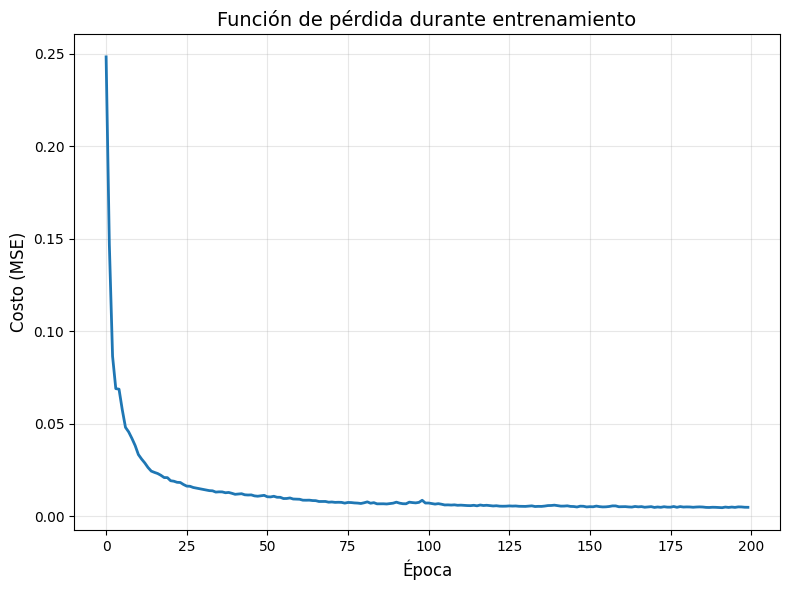

In [24]:
modeloLSTM = model_lstm_adam(
    X_train,
    y_train,
    n_h= 78,                # Número de unidades del estado oculto
    learning_rate=0.001,    # Tasa de aprendizaje
    mini_batch_size=64,     # Tamaño del minibatch
    num_epochs=200,         # Número de épocas
    print_cost=True         # Mostrar el costo
)


<a name="3-6"></a>
### Ejercicio 9 - Predicción del modelo LSTM
Listo, ya haz entrenado tu modelo LSTM. Sin embargo, ahora queremos hacer predicciones con este. Tu función `lstm_forward` realiza una sola predicción sobre el número $T_x$ de pasos. Sin embargo, si queremos realizar predicciones sobre más instantes de tiempo, debemos actualizar las ventanas de tiempo y los valores de las ventanas con los valores predichos.

Para esto nuestra función `predict_lstm` recibe como parámetros la ventana actual `window`, el modelo `parameters` y el número de pasos `steps`. Nosotros extraemos los valores de las dimensiones necesarios e inicializamos el estado oculto inicial $h^{\langle 0\rangle}$ y una lista con los valores a predecir `future_LSTM_predictions`. Tu objetivo es implementar el bucle principal.

**Instrucciones**:
-  Ajusta el número de iteraciones en el bucle principal.
-  Realiza la predicción $\hat y$ utilizando la función `lstm_forward`.
    - Recuerda que la función `lstm_forward` retorna una tupla `(h,y,c,caches)`, en este caso solo nos interesa el valor `y`.
-  Guarda la predicción en la lista `future_LSTM_predictions`.
    - Aplana el tensor 2D para guardar un solo valor.
-  Actualiza una nueva ventana con el valor que acabas de predecir $\hat y$.
-  Actualiza la ventana redimensionándo la nueva ventana para tener forma `(1, 1, T_x)`.

In [25]:
# Función calificadora: predict_lstm

def predict_lstm(window, parameters, steps):
  """
  Realiza un número de predicciones con el modelo LSTM empezando desde una ventana dada.

  Argumentos:
  window -- Ventana de entrada inicial para la predicción, shape (n_x, 1, T_x)
  parameters -- Diccionario de Python con los parámetros entrenados (Wf, bf, Wu, bu, ...)
  steps -- Número de pasos de predicción a realizar

  Retorna:
  future_LSTM_predictions -- Una lista con las predicciones.
  """
  # Extraer dimensiones de la entrada.
  n_x, m, T_x = window.shape
  n_y, n_h = parameters["Wy"].shape

  # Lista para guardar las predicciones.
  future_LSTM_predictions_scaled = []
  # Inicializa el primer estado oculto con ceros.
  h0 = np.zeros((n_h, 1))

  ## START CODE HERE ##
  # Itera hasta el número de pasos dado en el parámetro steps.
  for _ in range(steps):
    # Realiza la prediccion sobre el conjunto de datos y de parámetros.
    h, y, c, caches = lstm_forward(window, h0, parameters)

    # Guarda la prediccion, aplana el tensor 2D utilizando .flatten().
    future_LSTM_predictions_scaled.append(y.flatten()[0])

    # Actualiza los valores de la ventana. Aplana el tensor de la ventana primero.
    new_window_values = np.append(window.flatten()[1:], y.flatten())

    # Redimensiona la ventana actual para mantener la forma (1,1,T_x).
    window = new_window_values.reshape(1, 1, T_x)
  ## END CODE HERE ##

  #Desnormaliza los datos
  future_LSTM_predictions = scaler.inverse_transform(np.array(future_LSTM_predictions_scaled).reshape(-1, 1))

  return future_LSTM_predictions.flatten()

In [56]:
predict_lstm_test(predict_lstm)

Test Aprobado


### Predicción
Ahora veamos la predicción del modelo para los doce meses próximos del dataset.

In [65]:
# Tomamos la última ventana de datos conocida del conjunto de prueba
current_window = X_test[:, -1:, :]
test_LSTM_prediction = predict_lstm(current_window, modeloLSTM, 24)

print("Predicciones de inflación para los próximos 24 meses:")
print(test_LSTM_prediction)

Predicciones de inflación para los próximos 24 meses:
[-0.0687266  -0.03965383 -0.02009733 -0.00229494  0.0189143   0.04689877
  0.08347649  0.12784122  0.17946547  0.23713425  0.29995835  0.36902292
  0.4456557   0.53019043  0.62122217  0.71460792  0.80218655  0.87079052
  0.90340987  0.88451167  0.80800054  0.68212108  0.52700542  0.36636727]


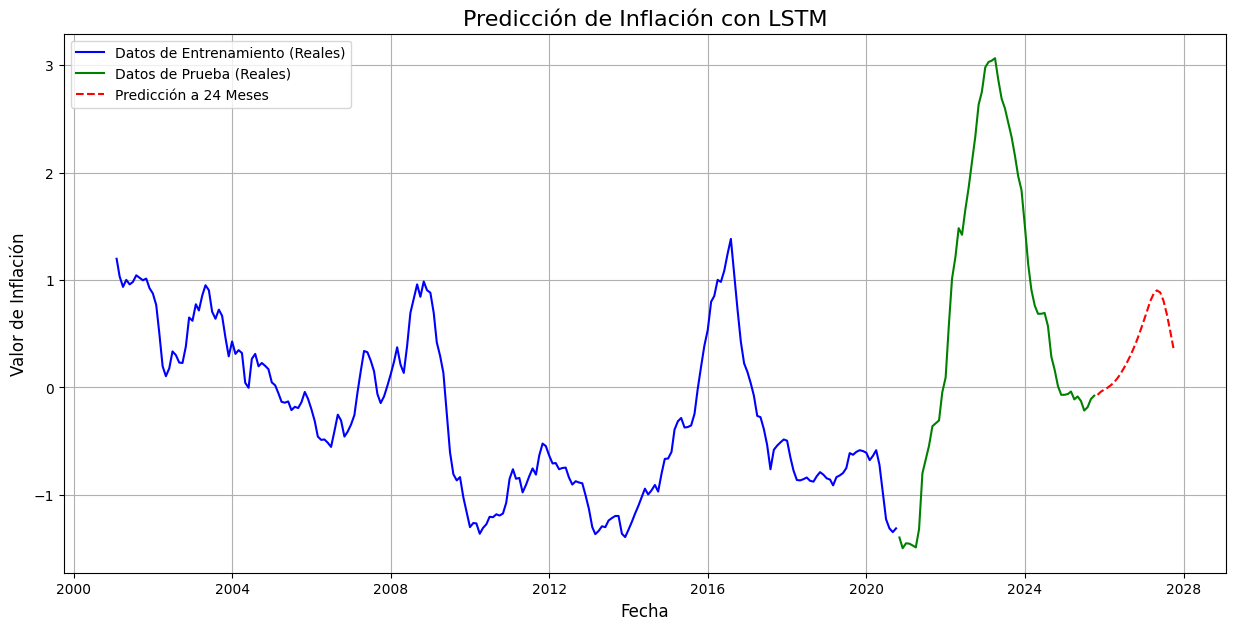

In [67]:
# Des-normalizar los datos para la gráfica
y_train_actual = scaler.inverse_transform(y_train_keras.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test_keras.reshape(-1, 1))

# Crea un índice de fechas para la gráfica
# Los índices de las secuencias corresponden a la *última* fecha de cada ventana.
# Por lo tanto, y_train[i] corresponde a data.index[i + n_steps_in].
start_train_index = n_steps_in
end_train_index = start_train_index + train_size
train_dates = data.index[start_train_index:end_train_index]

start_test_index = end_train_index
end_test_index = start_test_index + len(y_test_keras)
test_dates = data.index[start_test_index:end_test_index]
# Crear fechas futuras para las predicciones
# La primera fecha futura es el mes siguiente a la última fecha de prueba
future_dates = pd.date_range(start=test_dates[-1], periods=25, freq='ME')[1:]
# Graficar los resultados
plt.figure(figsize=(15, 7))

# Datos originales
plt.plot(train_dates, y_train_actual, label='Datos de Entrenamiento (Reales)', color='blue')
plt.plot(test_dates, y_test_actual, label='Datos de Prueba (Reales)', color='green')

# Predicciones
# future_predictions ya está desnormalizado
plt.plot(future_dates, test_LSTM_prediction, label='Predicción a 24 Meses', color='red', linestyle='--')

# Estilo del gráfico
plt.title('Predicción de Inflación con LSTM', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Valor de Inflación', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

<a name="4"></a>
## Segundo Modelo: Construyendo una GRU

<a name="4-1"></a>
### Ejercicio 10 - Celda del Forward Pass

In [31]:
# Función calificadora: gru_cell_forward

def gru_cell_forward(xt, h_prev, parameters):
    """
    Implementa un solo paso hacia adelante de la celda GRU como se describe en la Figura (4)

    Argumentos:
    xt -- tus datos de entrada en el paso de tiempo "t", numpy array de forma (n_x, m).
    h_prev -- Estado oculto en el paso de tiempo "t-1", numpy array de forma (n_h, m)
    parameters -- diccionario de python que contiene:
                        Wu -- Matriz de pesos de la compuerta de actualización, numpy array de forma (n_h, n_h + n_x)
                        bu -- Sesgo de la compuerta de actualización, numpy array de forma (n_h, 1)
                        Wh -- Matriz de pesos del valor candidato, numpy array de forma (n_h, n_h + n_x)
                        bh --  Sesgo del valor candidato, numpy array de forma (n_h, 1)
                        Wr -- Matriz de pesos de la compuerta de reinicio, numpy array de forma (n_h, n_h + n_x)
                        br -- Sesgo de la compuerta de reinicio, numpy array de forma (n_h, 1)


    Returns:
    h_next -- siguiente estado oculto, de forma (n_h, m)
    cache -- tupla de valores necesarios para el paso hacia atrás, contiene (h_next, h_prev, ut, rt, hht, xt, parameters)

    Nota: ut/rt significan las compuertas de actualización/reinicio, hh significa el valor candidato (h tilde).
    """

    # Recuperar parámetros de "parameters"
    Wu = parameters["Wu"]
    bu = parameters["bu"]
    Wh = parameters["Wh"]
    bh = parameters["bh"]
    Wr = parameters["Wr"]
    br = parameters["br"]


    # Recuperar dimensiones de las formas de xt
    n_x, m = xt.shape
    n_h, _ = h_prev.shape # Asumiendo que la forma de h_prev es (n_h, m)

    ### START CODE HERE ###
    # Concatenar h_prev y xt
    concat = np.concatenate((h_prev,xt))

    # Calcular valores para ut, rt, hht, h_next usando las fórmulas dadas en la figura (4)
    ut = sigmoid(np.dot(Wu,concat) + bu)
    rt = sigmoid(np.dot(Wr,concat) + br)
    ht = rt * h_prev
    aconcat = np.concatenate((ht,xt))
    hht = np.tanh(np.dot(Wh,aconcat) + bh)
    h_next = (1-ut) * h_prev + ut * hht
    ### END CODE HERE ###

    # almacenar valores necesarios para la propagación hacia atrás en la caché
    cache = (h_next, h_prev, ut, rt, hht, xt, parameters)

    return h_next, cache

In [32]:
gru_cell_forward_test(gru_cell_forward)

Test Aprobado


<a name="4-2"></a>
### Ejercicio 11 - Forward Pass

In [33]:
# Función calificadora: gru_forward

def gru_forward(x, h0, parameters):
    """
    Implementa la propagación hacia adelante de la red neuronal recurrente usando una celda GRU descrita en la Figura (4).

    Argumentos:
    x -- Datos de entrada para cada paso de tiempo, de forma (n_x, m, T_x).
    h0 -- Estado oculto inicial, de forma (n_h, m)
    parameters -- diccionario de python que contiene:
                        Wu -- Matriz de pesos de la compuerta de actualización, numpy array de forma (n_h, n_h + n_x)
                        bu -- Sesgo de la compuerta de actualización, numpy array de forma (n_h, 1)
                        Wh -- Matriz de pesos del valor candidato, numpy array de forma (n_h, n_h + n_x)
                        bh -- Sesgo del valor candidato, numpy array de forma (n_h, 1)
                        Wr -- Matriz de pesos de la compuerta de reinicio, numpy array de forma (n_h, n_h + n_x)
                        br -- Sesgo de la compuerta de reinicio, numpy array de forma (n_h, 1)
                        Wy -- Matriz de pesos que relaciona el estado oculto con la salida, numpy array de forma (n_y, n_h)
                        by -- Sesgo que relaciona el estado oculto con la salida, numpy array de forma (n_y, 1)

    Returns:
    h -- Estados ocultos para cada paso de tiempo, numpy array de forma (n_h, m, T_x)
    y -- Predicciones para cada paso de tiempo, numpy array de forma (n_y, m)
    caches -- tupla de valores necesarios para el paso hacia atrás, contiene (lista de todas las cachés, x)
    """

    # Inicializar "caches", que rastreará la lista de todas las cachés
    caches = []

    ### START CODE HERE ###
    Wy = parameters['Wy'] # guardar parameters['Wy'] en una variable local en caso de que los estudiantes usen Wy en lugar de parameters['Wy']
    by = parameters['by'] # guardar parameters['by']

    # Recuperar dimensiones de las formas de x y parameters['Wy'] (≈2 líneas)
    n_x, m, T_x = x.shape
    n_y, n_h = Wy.shape

    # inicializar "h" y "y" con ceros (≈2 líneas)
    h = np.zeros((n_h,m,T_x))
    y = np.zeros((n_y,m,1)) # Forma ajustada

    # Inicializar h_next (≈1 línea)
    h_next = h0

    # iterar sobre todos los pasos de tiempo
    for t in range(T_x): # Iterar a través de todos los pasos de tiempo
        # Obtener la sección 2D 'xt' de la entrada 3D 'x' en el paso de tiempo 't'
        xt = x[:,:,t]
        # Actualizar el siguiente estado oculto, calcular la predicción, obtener la caché
        h_next, cache = gru_cell_forward(xt,h_next,parameters)

        # Guardar el valor del nuevo estado oculto "siguiente" en h
        h[:,:,t] = h_next
        # Añadir la caché a caches
        caches.append(cache)
    ### END CODE HERE ###
    y = np.dot(Wy,h[:,:,-1]) + by
    # almacenar valores necesarios para la propagación hacia atrás en la caché
    caches = (caches, x)

    return h, y, caches

In [34]:
gru_cell_forward_test(gru_cell_forward)

Test Aprobado


<a name="4-3"></a>
### Ejercicio 12 - Celda del Backward pass

In [35]:
# Función calificadora: gru_cell_backward

def gru_cell_backward(dh_next, cache):
    """
    Implementa el paso hacia atrás para la celda GRU (un solo paso de tiempo).

    Argumentos:
    dh_next -- Gradientes del siguiente estado oculto, de forma (n_h, m)
    cache -- caché que almacena información del paso hacia adelante

    Returns:
    gradients -- diccionario de python que contiene:
                        dxt -- Gradiente de los datos de entrada en el paso de tiempo t, de forma (n_x, m)
                        dh_prev -- Gradiente con respecto al estado oculto anterior, numpy array de forma (n_h, m)
                        dWr -- Gradiente con respecto a la matriz de pesos de la compuerta de reinicio, numpy array de forma (n_h, n_h + n_x)
                        dbr -- Gradiente con respecto a los sesgos de la compuerta de reinicio, de forma (n_h, 1)
                        dWu -- Gradiente con respecto a la matriz de pesos de la compuerta de actualización, numpy array de forma (n_h, n_h + n_x)
                        dbu -- Gradiente con respecto a los sesgos de la compuerta de actualización, de forma (n_h, 1)
                        dWh -- Gradiente con respecto a la matriz de pesos del estado oculto candidato, numpy array de forma (n_h, n_h + n_x)
                        dbh -- Gradiente con respecto a los sesgos del estado oculto candidato, de forma (n_h, 1)
    """

    # Recuperar información de "cache"
    (h_next, h_prev, ut, rt, hht, xt, parameters) = cache

    Wh = parameters['Wh']
    Wu = parameters['Wu']
    Wr = parameters['Wr']
    concat_c = np.concatenate((rt*h_prev,xt),axis=0).T
    ### START CODE HERE ###
    # Recuperar dimensiones de las formas de xt y h_next
    n_x, m = xt.shape
    n_h, m = h_next.shape

    # Calcular derivadas relacionadas con las compuertas. Sus valores se pueden encontrar observando cuidadosamente las ecuaciones (7) a (10)
    dhht = (dh_next * ut) * (1 - np.power(np.tanh(hht),2))
    dut = (dh_next * (hht - h_prev)) * ut * (1 - ut)
    tmp = np.dot(Wh[:, :n_h].T, dhht)
    drt = (tmp * h_prev) * rt * (1 - rt)


    # Calcular derivadas relacionadas con los parámetros. Usar ecuaciones (11)-(18)
    concat_t = np.concatenate((h_prev,xt),axis=0).T
    dWr = np.dot(drt,concat_t)
    dWu = np.dot(dut,concat_t)
    dWh = np.dot(dhht,concat_c)
    dbr = np.sum(drt,axis=1,keepdims=True)
    dbu = np.sum(dut,axis=1,keepdims=True)
    dbh = np.sum(dhht,axis=1,keepdims=True)

    # Calcular derivadas con respecto al estado oculto anterior y entrada. Usar ecuaciones (19)-(21).
    dh_prev = dh_next * (1 - ut) + np.dot(Wu[:, :n_h].T, dut) + np.dot(Wr[:, :n_h].T,drt) + rt * np.dot(Wh[:, :n_h].T, dhht)
    dxt = np.dot(Wu[:, n_h:].T, dut) + np.dot(Wr[:, n_h:].T, drt) + np.dot(Wh[:, n_h:].T, dhht)


    ### END CODE HERE ###



    # Guardar gradientes en el diccionario
    gradients = {"dxt": dxt, "dh_prev": dh_prev, "dWr": dWr,"dbr": dbr, "dWu": dWu,"dbu": dbu,
                 "dWh": dWh, "dbh": dbh}

    return gradients

In [36]:
gru_cell_backward_test(gru_cell_backward,gru_cell_forward)

Test Aprobado


<a name="4-4"></a>
### Ejercicio 13 - Backward pass

In [37]:
# UNGRADED FUNCTION: lstm_backward

def gru_backward(dh, caches, m_batch):

    """
    Implementa el paso hacia atrás para la RNN con celda GRU (sobre una secuencia completa).

    Argumentos:
    dh -- Gradientes con respecto a los estados ocultos, numpy-array de forma (n_h, m, T_x)
    caches -- caché que almacena información del paso hacia adelante (gru_forward)
    m_batch -- El tamaño del minibatch, entero

    Returns:
    gradients -- diccionario de python que contiene:
                        dx -- Gradiente de las entradas, de forma (n_x, m, T_x)
                        dh0 -- Gradiente con respecto al estado oculto anterior, numpy array de forma (n_h, m)
                        dWr -- Gradiente con respecto a la matriz de pesos de la compuerta de reinicio, numpy array de forma (n_h, n_h + n_x)
                        dWu -- Gradiente con respecto a la matriz de pesos de la compuerta de actualización, numpy array de forma (n_h, n_h + n_x)
                        dWc -- Gradiente con respecto a la matriz de pesos del valor candidato, numpy array de forma (n_h, n_h + n_x)
                        dbr -- Gradiente con respecto a los sesgos de la compuerta de reinicio, de forma (n_h, 1)
                        dbu -- Gradiente con respecto a los sesgos de la compuerta de actualización, de forma (n_h, 1)
                        dbc -- Gradiente con respecto a los sesgos del valor candidato, de forma (n_h, 1)
    """

    # Recuperar valores de la primera caché (t=1) de caches.
    (caches, x) = caches
    (h1, h0, u1, r1, cc1, x1, parameters) = caches[0]

    ### START CODE HERE ###
    # Recuperar dimensiones de las formas de dh y x1
    n_h, m, T_x = dh.shape
    n_x, m = x1.shape

    # inicializar los gradientes con los tamaños correctos
    dx = np.zeros((n_x,m,T_x))
    dh0 = np.zeros((n_h,m))
    dh_prevt =  np.zeros((n_h,m))
    dWu = np.zeros((n_h,n_h + n_x))
    dWr = np.zeros((n_h,n_h + n_x))
    dWh = np.zeros((n_h,n_h + n_x)) # dWc inicializado
    dbu = np.zeros((n_h,1))
    dbr = np.zeros((n_h,1))
    dbh = np.zeros((n_h,1)) # dbc inicializado


    # iterar hacia atrás sobre toda la secuencia
    for t in reversed(range(T_x)):
        # Calcular todos los gradientes usando gru_cell_backward. Elegir sabiamente el "dh_next".
        gradients = gru_cell_backward(dh[:,:,t]+dh_prevt, cache=caches[t])
        # Almacenar o añadir el gradiente al gradiente del paso anterior de los parámetros
        dh_prevt = gradients["dh_prev"]
        dx[:,:,t] = gradients["dxt"]
        dWr += gradients["dWr"]
        dWu += gradients["dWu"]
        dWh += gradients["dWh"]
        dbu += gradients["dbu"]
        dbr += gradients["dbr"]
        dbh += gradients["dbh"]
    # Establecer el gradiente de la primera activación al gradiente retropropagado dh_prev.
    dh0 = dh_prevt

    ### END CODE HERE ###
    dWr /= m_batch; dWu /= m_batch; dWh /= m_batch
    dbr /= m_batch; dbu /= m_batch; dbh /= m_batch
    # Almacenar los gradientes en un diccionario de python
    gradients = {"dx": dx, "dh0": dh0, "dWr": dWr,"dbr": dbr, "dWu": dWu,"dbu": dbu,
                 "dWh": dWh, "dbh": dbh}

    return gradients

In [38]:
gru_backward_test(gru_backward,gru_cell_backward,gru_cell_forward)

Test Aprobado


### Inicialización de Parámetros de GRU

In [40]:
def initialize_GRU_parameters(n_h, n_x, n_y):
    """
    Inicializa los parámetros de la GRU con Xavier initialization

    Arguments:
    n_h -- número de unidades en el hidden state
    n_x -- número de features de entrada
    n_y -- número de features de salida

    Returns:
    parameters -- diccionario con los parámetros inicializados
    """
    np.random.seed(1)

    parameters = {}

    # Xavier initialization para mejores resultados
    parameters['Wu'] = np.random.randn(n_h, n_h + n_x) * np.sqrt(2.0 / (n_h + n_x))
    parameters['bu'] = np.zeros((n_h, 1))

    parameters['Wr'] = np.random.randn(n_h, n_h + n_x) * np.sqrt(2.0 / (n_h + n_x))
    parameters['br'] = np.zeros((n_h, 1))

    parameters['Wh'] = np.random.randn(n_h, n_h + n_x) * np.sqrt(2.0 / (n_h + n_x))
    parameters['bh'] = np.zeros((n_h, 1))

    parameters['Wy'] = np.random.randn(n_y, n_h) * np.sqrt(2.0 / n_h)
    parameters['by'] = np.zeros((n_y, 1))

    return parameters

In [41]:
initialize_GRU_parameters_test(initialize_GRU_parameters)

Test Aprobado


<a name="4-5"></a>
### Ejercicio 14 - Entrenamiento del modelo GRU

In [42]:
# Función calificadora: model_gru_adam

def model_gru_adam(X, Y, n_h, learning_rate=0.001, mini_batch_size=32,
                    beta1=0.9, beta2=0.999, epsilon=1e-8,
                    num_epochs=1000, print_cost=True):
    """
    Entrena una GRU desde cero con Adam y minibatches.

    Arguments:
    X -- datos de entrada, numpy array (n_x, m, T_x)
    Y -- datos objetivo, numpy array (n_y, m, 1)
    n_a -- número de unidades del estado oculto
    learning_rate -- tasa de aprendizaje Adam
    mini_batch_size -- tamaño de minibatch
    num_epochs -- número de épocas
    """

    n_x, m, T_x = X.shape
    n_y, _, _ = Y.shape # Y la forma es (n_y, m, 1)

    # Inicialización
    parameters = initialize_GRU_parameters(n_h, n_x, n_y)
    v, s = initialize_adam(parameters)
    seed = 10
    costs = []
    t = 0  # contador de pasos de Adam

    for epoch in range(num_epochs):
        seed += 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        epoch_cost = 0

        for minibatch_X, minibatch_Y in minibatches:
            # Inicialización del estado oculto
            m_batch = minibatch_X.shape[1]
            h0 = np.zeros((n_h, m_batch))

            # Forward pass
            h, y_pred, caches = gru_forward(minibatch_X, h0, parameters) # y_pred forma (n_y, m, 1)

            # Costo (MSE) - Necesita comparar y_pred (n_y, m, 1) con minibatch_Y (n_y, m, 1)
            # Necesitamos comparar la última predicción de la secuencia con el objetivo
            cost = compute_cost(y_pred, minibatch_Y.squeeze(axis=2)) # Comparar la última predicción con el objetivo

            # Backward pass
            # Inicializar gradientes ascendentes para estados ocultos
            dh = np.zeros_like(h) # forma (n_h, m_batch, T_x)

            # Calcular el gradiente del costo con respecto a la capa de salida en el último paso de tiempo

            # Gradiente del costo con respecto a la predicción de salida en el último paso de tiempo
            dcost_dy_pred_last = (y_pred - minibatch_Y.squeeze(axis=2)) / m_batch # forma (n_y, m_batch)

            # Gradiente del costo con respecto al argumento de la sigmoide en el último paso de tiempo (zt)
            zt_last = np.dot(parameters['Wy'], h[:,:,-1]) + parameters['by'] # forma (n_y, m_batch)

            dcost_dzt_last = np.squeeze(dcost_dy_pred_last)
            if dcost_dzt_last.ndim == 1:
                dcost_dzt_last = dcost_dzt_last.reshape(1, -1)

            # Gradiente hacia el último estado oculto
            dh[:, :, -1] = np.dot(parameters['Wy'].T, dcost_dzt_last)

            # Retropropagar a través de la secuencia GRU
            # Necesitamos pasar dh[:,:,-1] a gru_backward como el dh_next inicial
            grads = gru_backward(dh, caches, m_batch)

            # Añadir gradientes para Wy y by (calculados a partir de la capa de salida)
            # dCosto/dWy = dCosto/dzt * dzt/dWy = dcost_dzt_last @ h_next.T
            grads['dWy'] = np.dot(dcost_dzt_last, h[:,:,-1].T) # forma (n_y, n_h)
            # dCosto/dby = dCosto/dzt * dzt/dby = sum(dcost_dzt_last, axis=1, keepdims=True)
            grads['dby'] = np.sum(dcost_dzt_last, axis=1, keepdims=True) # forma (n_y, 1)

            # Recortar gradientes
            grads = clip_gradients(grads, 5.0)

            # Update Adam
            t += 1
            parameters, v, s = update_parameters_with_adam(parameters, grads, v, s, t,
                                                        learning_rate, beta1, beta2, epsilon)

            epoch_cost += cost / len(minibatches)

        # Guardar costo
        if print_cost:
            print(f"Cost after epoch {epoch}: {epoch_cost:.6f}")
            costs.append(epoch_cost)

    # Graficar costos
    if print_cost:
      plot_training(costs)


    return parameters

In [43]:
model_gru_adam_test(model_gru_adam)

Test Aprobado


Cost after epoch 0: 0.050618
Cost after epoch 1: 0.040537
Cost after epoch 2: 0.028631
Cost after epoch 3: 0.025555
Cost after epoch 4: 0.021133
Cost after epoch 5: 0.020002
Cost after epoch 6: 0.018271
Cost after epoch 7: 0.017990
Cost after epoch 8: 0.017369
Cost after epoch 9: 0.016663
Cost after epoch 10: 0.015907
Cost after epoch 11: 0.014755
Cost after epoch 12: 0.014661
Cost after epoch 13: 0.014159
Cost after epoch 14: 0.013723
Cost after epoch 15: 0.013231
Cost after epoch 16: 0.012942
Cost after epoch 17: 0.012684
Cost after epoch 18: 0.012507
Cost after epoch 19: 0.012447
Cost after epoch 20: 0.011382
Cost after epoch 21: 0.011459
Cost after epoch 22: 0.011267
Cost after epoch 23: 0.011227
Cost after epoch 24: 0.010579
Cost after epoch 25: 0.010333
Cost after epoch 26: 0.010415
Cost after epoch 27: 0.010391
Cost after epoch 28: 0.010254
Cost after epoch 29: 0.010024
Cost after epoch 30: 0.009758
Cost after epoch 31: 0.009763
Cost after epoch 32: 0.009821
Cost after epoch 33:

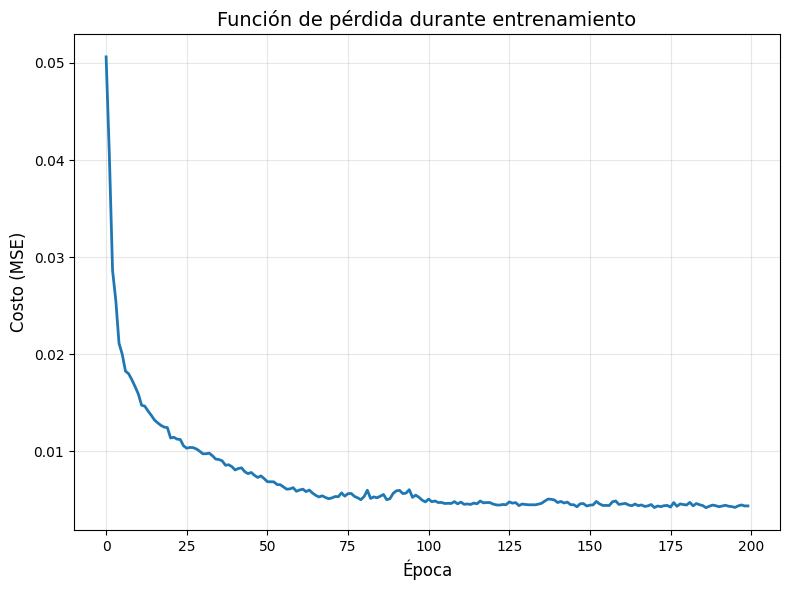

In [44]:
modeloGRU = model_gru_adam(
    X_train,
    y_train,
    n_h= 78,                # número de unidades del estado oculto
    learning_rate=0.001,  # tasa de aprendizaje
    mini_batch_size=64,   # tamaño del minibatch (puedes ajustar)
    num_epochs=200,        # número de épocas
    print_cost=True       # mostrar el costo
)


<a name="4-6"></a>
### Predicción del modelo GRU

In [46]:
def predict_gru(window, parameters, steps=1):
  """
  Realiza un número de predicciones con el modelo GRU empezando desde una ventana dada.

  Argumentos:
    window -- Ventana de entrada inicial para la predicción, shape (n_x, 1, T_x)
    parameters -- Diccionario de Python con los parámetros entrenados (Wr, br, Wu, bu, ...)
    steps -- Número de pasos de predicción a realizar

    Retorna:
    future_GRU_predictions -- Una lista con las predicciones.
  """
  # Extraer dimensiones de la entrada.
  n_x, m, T_x = window.shape
  n_y, n_h = parameters["Wy"].shape

  # Lista para guardar las predicciones.
  future_GRU_predictions_scaled = []
  # Inicializa el primer estado oculto con ceros.
  h0 = np.zeros((n_h, 1))

  # Itera hasta el número de pasos dado en el parámetro steps.
  for _ in range(steps):
    # Realiza la prediccion sobre el conjunto de datos y de parámetros.
    h, y, caches = gru_forward(window, h0, parameters)

    # Guarda la prediccion, aplana el tensor 2D utilizando .flatten().
    future_GRU_predictions_scaled.append(y.flatten()[0])

    # Actualiza los valores de la ventana.
    new_window_values = np.append(window.flatten()[1:], y.flatten())

    # Redimensiona la ventana actual para mantener la forma (1,1,T_x).
    window = new_window_values.reshape(1, 1, T_x)

  #Desnormaliza los datos
  future_GRU_predictions = scaler.inverse_transform(np.array(future_GRU_predictions_scaled).reshape(-1, 1))

  return future_GRU_predictions.flatten()

In [69]:
# Tomamos la última ventana de datos conocida del conjunto de prueba
current_window = X_test[:, -1:, :]
test_GRU_prediction = predict_gru(current_window,modeloGRU,24)


print("Predicciones de inflación para los próximos 24 meses:")
print(test_GRU_prediction.flatten())

Predicciones de inflación para los próximos 24 meses:
[-0.0654115  -0.03547986 -0.01337444  0.00370258  0.02081831  0.04387347
  0.07779218  0.12280775  0.17851285  0.24191612  0.30771282  0.37407204
  0.44270673  0.5153522   0.59193605  0.66912718  0.73999985  0.7949376
  0.82343805  0.81637737  0.76836006  0.68010158  0.55996512  0.42310318]


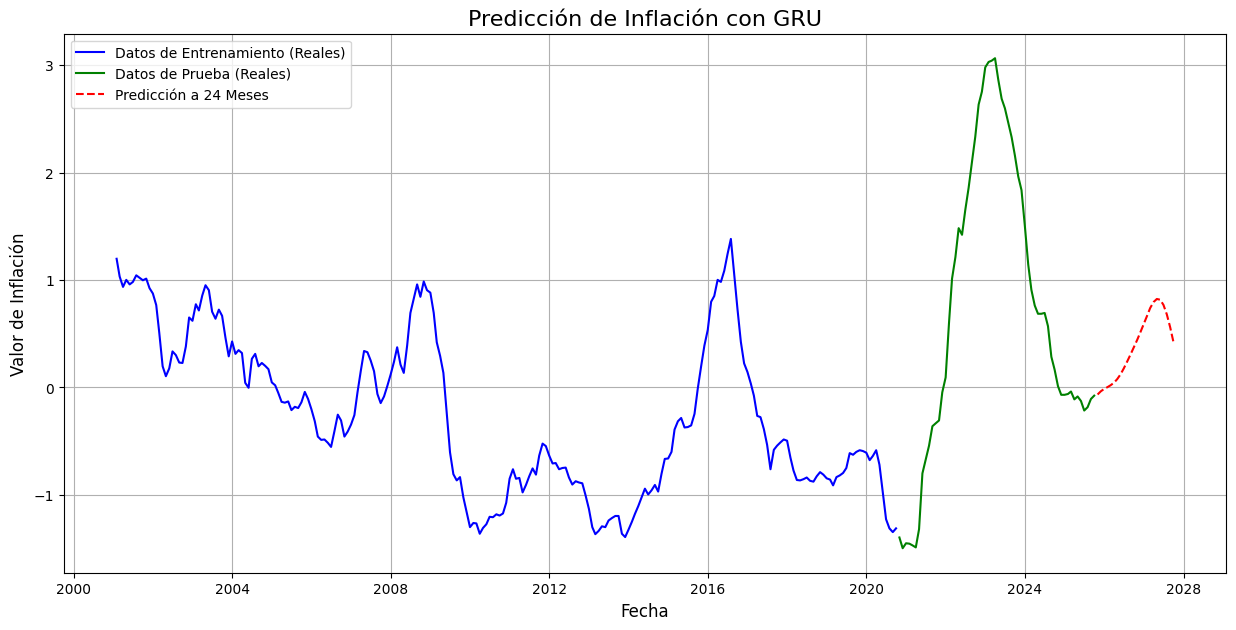

In [70]:
# Des-normalizar los datos para la gráfica
y_train_actual = scaler.inverse_transform(y_train_keras.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test_keras.reshape(-1, 1))

# Crea un índice de fechas para la gráfica
# Los índices de las secuencias corresponden a la *última* fecha de cada ventana.
# Por lo tanto, y_train[i] corresponde a data.index[i + n_steps_in].
start_train_index = n_steps_in
end_train_index = start_train_index + train_size
train_dates = data.index[start_train_index:end_train_index]

start_test_index = end_train_index
end_test_index = start_test_index + len(y_test_keras)
test_dates = data.index[start_test_index:end_test_index]
# Crear fechas futuras para las predicciones
# La primera fecha futura es el mes siguiente a la última fecha de prueba
future_dates = pd.date_range(start=test_dates[-1], periods=25, freq='ME')[1:]
# Graficar los resultados
plt.figure(figsize=(15, 7))

# Datos originales
plt.plot(train_dates, y_train_actual, label='Datos de Entrenamiento (Reales)', color='blue')
plt.plot(test_dates, y_test_actual, label='Datos de Prueba (Reales)', color='green')

# Predicciones
# future_predictions ya está desnormalizado
plt.plot(future_dates, test_GRU_prediction, label='Predicción a 24 Meses', color='red', linestyle='--')

# Estilo del gráfico
plt.title('Predicción de Inflación con GRU', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Valor de Inflación', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

<a name="5"></a>
## Implementación con Keras
Ahora vamos a realizar una comparación entre nuestro modelo y uno creado con Keras.

Primero cargamos las librerias necesarias.

#### Implementación de LSTM

In [57]:
modeloLSTM_Keras = Sequential()
modeloLSTM_Keras.add(LSTM(units=78, input_shape=(X_train.shape[1], 1)))
modeloLSTM_Keras.add(Dense(1))

modeloLSTM_Keras.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')
historyLSTM = modeloLSTM_Keras.fit(X_train_keras, y_train_keras, epochs=200, batch_size=64, verbose=1)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.6625
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.4098
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2474
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1837 
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1903
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1589
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1341
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1489
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1252
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1245
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1156
Epoch 12/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1054
Epoch 13/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0996
Epoch 14/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0877
Epoch 15/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0841
Epoch 16/200
4/4 ━

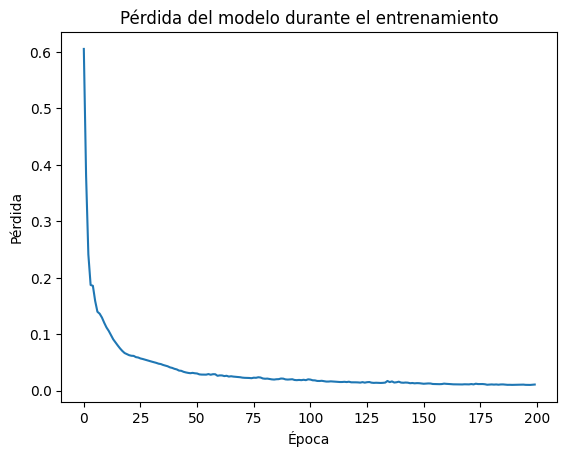

In [58]:
# Graficar la función de pérdida
plt.plot(historyLSTM.history['loss'])
plt.title('Pérdida del modelo durante el entrenamiento')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.show()

In [59]:
# Predicción para el próximo año
seq_lenght = 12 # n_steps_in

# Tomar la última secuencia de los datos escalados para la predicción inicial
current_window_keras = inflation_scaled[-n_steps_in:].reshape(1, n_steps_in, 1)

# Lista para almacenar las predicciones de 24 meses
future_LSTM_keras_predictions_scaled = []

for _ in range(24):
    # Hacer una predicción para el siguiente paso
    next_step_pred_scaled = modeloLSTM_Keras.predict(current_window_keras, verbose=0)

    # Almacenar la predicción
    future_LSTM_keras_predictions_scaled.append(next_step_pred_scaled[0, 0])

    # Actualizar la ventana: eliminar el valor más antiguo y añadir la nueva predicción
    # Asegurar que current_window_keras permanezca (1, n_steps_in, 1)
    new_window_values = np.append(current_window_keras.flatten()[1:], next_step_pred_scaled.flatten())
    current_window_keras = new_window_values.reshape(1, n_steps_in, 1)

# Desnormalizar todas las 24 predicciones
future_LSTM_keras = scaler.inverse_transform(np.array(future_LSTM_keras_predictions_scaled).reshape(-1, 1))

print("Predicciones de inflación para los próximos 24 meses con Keras:")
print(future_LSTM_keras.flatten())

Predicciones de inflación para los próximos 24 meses con Keras:
[-0.03487848  0.00801885  0.06253567  0.12723617  0.20195447  0.28611064
  0.37747616  0.47465986  0.5737893   0.6678135   0.74976146  0.81266177
  0.8489525   0.85268337  0.82117665  0.7566503   0.66656256  0.5625732
  0.45799282  0.36440042  0.28889123  0.23342113  0.19632325  0.17454247]


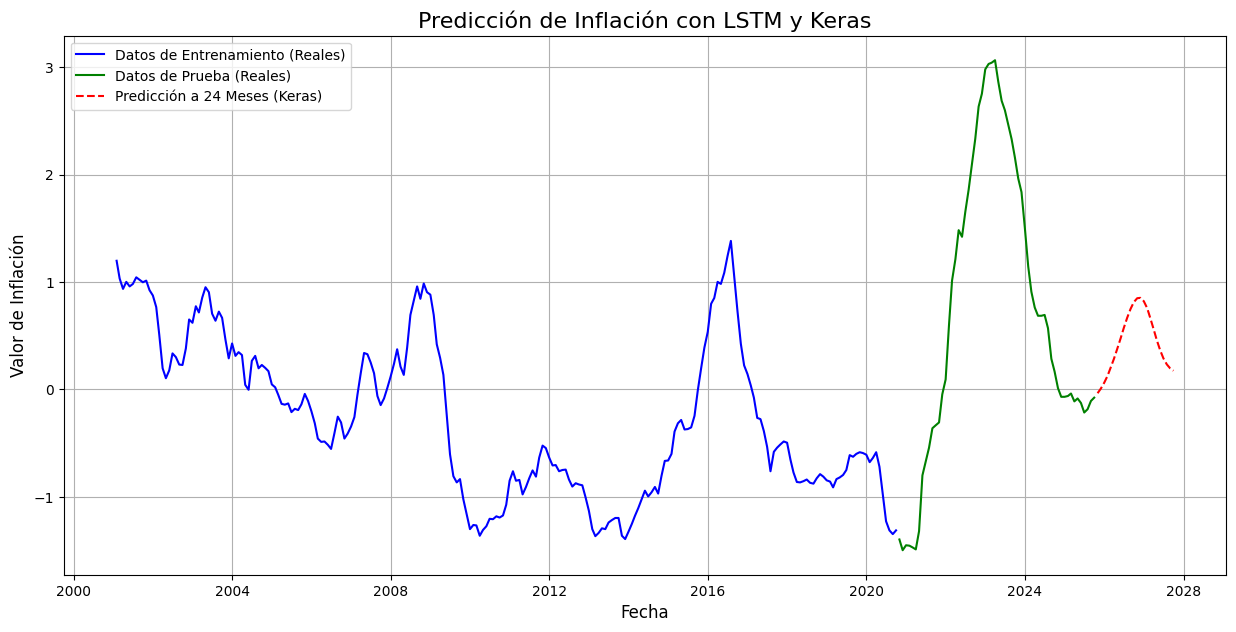

In [60]:
# Des-normalizar los datos para la gráfica
y_train_actual = scaler.inverse_transform(y_train_keras.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test_keras.reshape(-1, 1))

# Crea un índice de fechas para la gráfica
# Los índices de las secuencias corresponden a la *última* fecha de cada ventana.
# Por lo tanto, y_train[i] corresponde a data.index[i + n_steps_in].
start_train_index = n_steps_in
end_train_index = start_train_index + train_size
train_dates = data.index[start_train_index:end_train_index]

start_test_index = end_train_index
end_test_index = start_test_index + len(y_test_keras)
test_dates = data.index[start_test_index:end_test_index]
# Crear fechas futuras para las predicciones
# La primera fecha futura es el mes siguiente a la última fecha de prueba
future_dates = pd.date_range(start=test_dates[-1], periods=25, freq='ME')[1:]
# Graficar los resultados
plt.figure(figsize=(15, 7))

# Datos originales
plt.plot(train_dates, y_train_actual, label='Datos de Entrenamiento (Reales)', color='blue')
plt.plot(test_dates, y_test_actual, label='Datos de Prueba (Reales)', color='green')

# Predicciones
# future_predictions ya está desnormalizado
plt.plot(future_dates, future_LSTM_keras.flatten(), label='Predicción a 24 Meses (Keras)', color='red', linestyle='--')

# Estilo del gráfico
plt.title('Predicción de Inflación con LSTM y Keras', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Valor de Inflación', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

### Implementación de GRU

In [61]:
modeloGRU_Keras = Sequential()
modeloGRU_Keras.add(GRU(units=78, input_shape=(X_train.shape[1], 1)))
modeloGRU_Keras.add(Dense(1))

modeloGRU_Keras.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')
historyGRU = modeloGRU_Keras.fit(X_train_keras, y_train_keras, epochs=200, batch_size=64, verbose=1)

Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.6408
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3984
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2757
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1542
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1199
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0944
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0810
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0719
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0643
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0659
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0616
Epoch 12/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0571
Epoch 13/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0544
Epoch 14/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0470
Epoch 15/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0424
Epoch 16/200
4/4 ━━

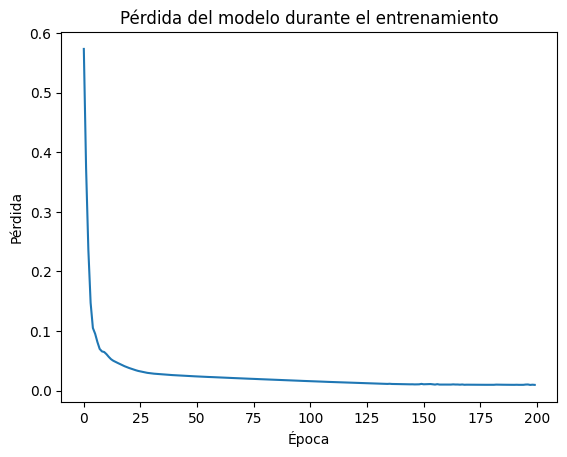

In [62]:
# Graficar la función de pérdida
plt.plot(historyGRU.history['loss'])
plt.title('Pérdida del modelo durante el entrenamiento')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.show()

In [63]:
# Predicción para el próximo año
seq_lenght = 12 # n_steps_in

# Tomar la última secuencia de los datos escalados para la predicción inicial
current_window_keras = inflation_scaled[-n_steps_in:].reshape(1, n_steps_in, 1)

# Lista para almacenar las predicciones de 24 meses
future_GRU_keras_predictions_scaled = []

for _ in range(24):
    # Hacer una predicción para el siguiente paso
    next_step_pred_scaled = modeloGRU_Keras.predict(current_window_keras, verbose=0)

    # Almacenar la predicción
    future_GRU_keras_predictions_scaled.append(next_step_pred_scaled[0, 0])

    # Actualizar la ventana: eliminar el valor más antiguo y añadir la nueva predicción
    # Asegurar que current_window_keras permanezca (1, n_steps_in, 1)
    new_window_values = np.append(current_window_keras.flatten()[1:], next_step_pred_scaled.flatten())
    current_window_keras = new_window_values.reshape(1, n_steps_in, 1)

# Desnormalizar todas las 24 predicciones
future_GRU_keras = scaler.inverse_transform(np.array(future_GRU_keras_predictions_scaled).reshape(-1, 1))

print("Predicciones de inflación para los próximos 24 meses con Keras:")
print(future_GRU_keras.flatten())

Predicciones de inflación para los próximos 24 meses con Keras:
[-0.06953151 -0.06219662 -0.04703718 -0.02841099 -0.00799207  0.01446144
  0.03893655  0.06556447  0.09425205  0.12466943  0.15701291  0.19187927
  0.22968282  0.27056637  0.3145799   0.36177582  0.41213143  0.4654205
  0.5210659   0.57793945  0.6340823   0.6863584   0.7301381   0.7592646 ]


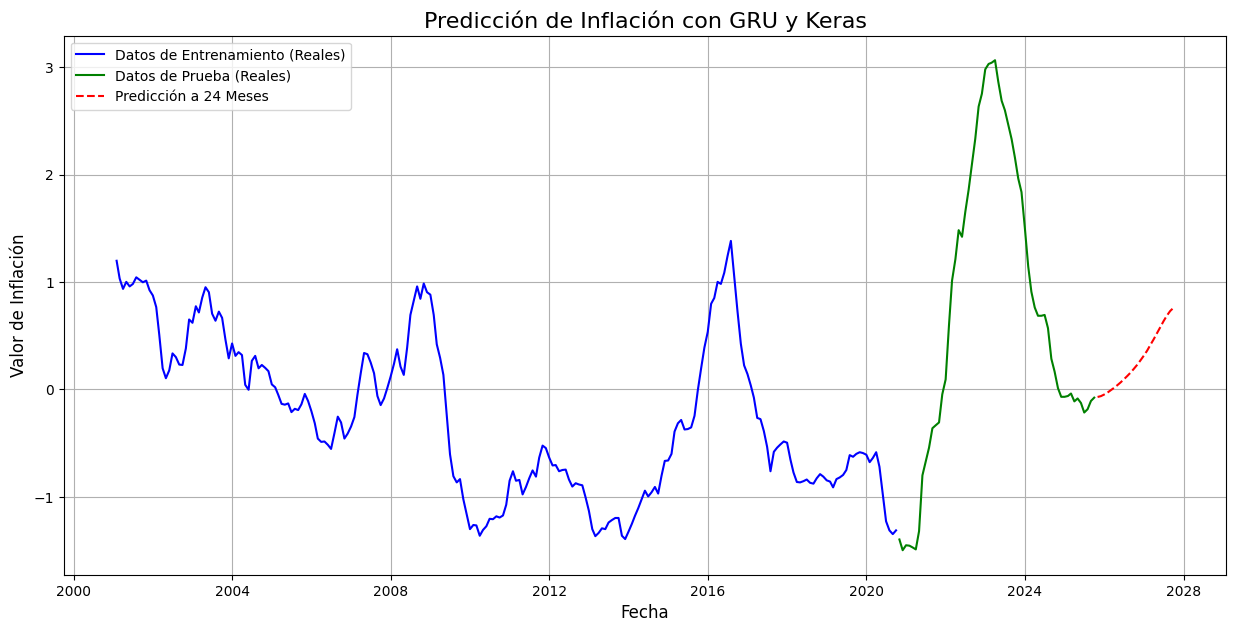

In [64]:
# Des-normalizar los datos para la gráfica
y_train_actual = scaler.inverse_transform(y_train_keras.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test_keras.reshape(-1, 1))

# Crea un índice de fechas para la gráfica
# Los índices de las secuencias corresponden a la *última* fecha de cada ventana.
# Por lo tanto, y_train[i] corresponde a data.index[i + n_steps_in].
start_train_index = n_steps_in
end_train_index = start_train_index + train_size
train_dates = data.index[start_train_index:end_train_index]

start_test_index = end_train_index
end_test_index = start_test_index + len(y_test_keras)
test_dates = data.index[start_test_index:end_test_index]
# Crear fechas futuras para las predicciones
# La primera fecha futura es el mes siguiente a la última fecha de prueba
future_dates = pd.date_range(start=test_dates[-1], periods=25, freq='ME')[1:]
# Graficar los resultados
plt.figure(figsize=(15, 7))

# Datos originales
plt.plot(train_dates, y_train_actual, label='Datos de Entrenamiento (Reales)', color='blue')
plt.plot(test_dates, y_test_actual, label='Datos de Prueba (Reales)', color='green')

# Predicciones
# future_predictions ya está desnormalizado
plt.plot(future_dates, future_GRU_keras.flatten(), label='Predicción a 24 Meses', color='red', linestyle='--')

# Estilo del gráfico
plt.title('Predicción de Inflación con GRU y Keras', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Valor de Inflación', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

### Actualizar predicciones (Keras)

In [72]:
m_test_lstm = X_test.shape[1]
h0_test_lstm = np.zeros((modeloLSTM['Wf'].shape[0], m_test_lstm))

# Realizar predicciones en el conjunto de prueba con el modelo LSTM implementado
_, y_pred_test_lstm_scaled, _, _ = lstm_forward(X_test, h0_test_lstm, modeloLSTM)

# Des-normalizar las predicciones del conjunto de prueba
y_pred_test_lstm_actual = scaler.inverse_transform(y_pred_test_lstm_scaled.reshape(-1, 1))

# Concatenar las predicciones del conjunto de prueba con las futuras
combined_LSTM_predictions = np.concatenate((y_pred_test_lstm_actual.squeeze(), test_LSTM_prediction))


In [73]:
# Realizar predicciones en el conjunto de prueba con el modelo LSTM de Keras
y_pred_test_lstm_keras_scaled = modeloLSTM_Keras.predict(X_test_keras, verbose=0)

# Des-normalizar las predicciones del conjunto de prueba
y_pred_test_lstm_keras_actual = scaler.inverse_transform(y_pred_test_lstm_keras_scaled.reshape(-1, 1))

# Concatenar las predicciones del conjunto de prueba con las futuras
combined_LSTM_keras_predictions = np.concatenate((y_pred_test_lstm_keras_actual, future_LSTM_keras))


In [76]:
m_test_gru = X_test.shape[1]
h0_test_gru = np.zeros((modeloGRU['Wu'].shape[0], m_test_gru))

# Realizar predicciones en el conjunto de prueba con el modelo GRU implementado
_, y_pred_test_gru_scaled, _ = gru_forward(X_test, h0_test_gru, modeloGRU)

# Des-normalizar las predicciones del conjunto de prueba
y_pred_test_gru_actual = scaler.inverse_transform(y_pred_test_gru_scaled.reshape(-1, 1))

# Concatenar las predicciones del conjunto de prueba con las futuras
combined_GRU_predictions = np.concatenate((y_pred_test_gru_actual.squeeze(), test_GRU_prediction))


In [75]:
# Realizar predicciones en el conjunto de prueba con el modelo GRU de Keras
y_pred_test_gru_keras_scaled = modeloGRU_Keras.predict(X_test_keras, verbose=0)

# Des-normalizar las predicciones del conjunto de prueba
y_pred_test_gru_keras_actual = scaler.inverse_transform(y_pred_test_gru_keras_scaled.reshape(-1, 1))

# Concatenar las predicciones del conjunto de prueba con las futuras
combined_GRU_keras_predictions = np.concatenate((y_pred_test_gru_keras_actual, future_GRU_keras))


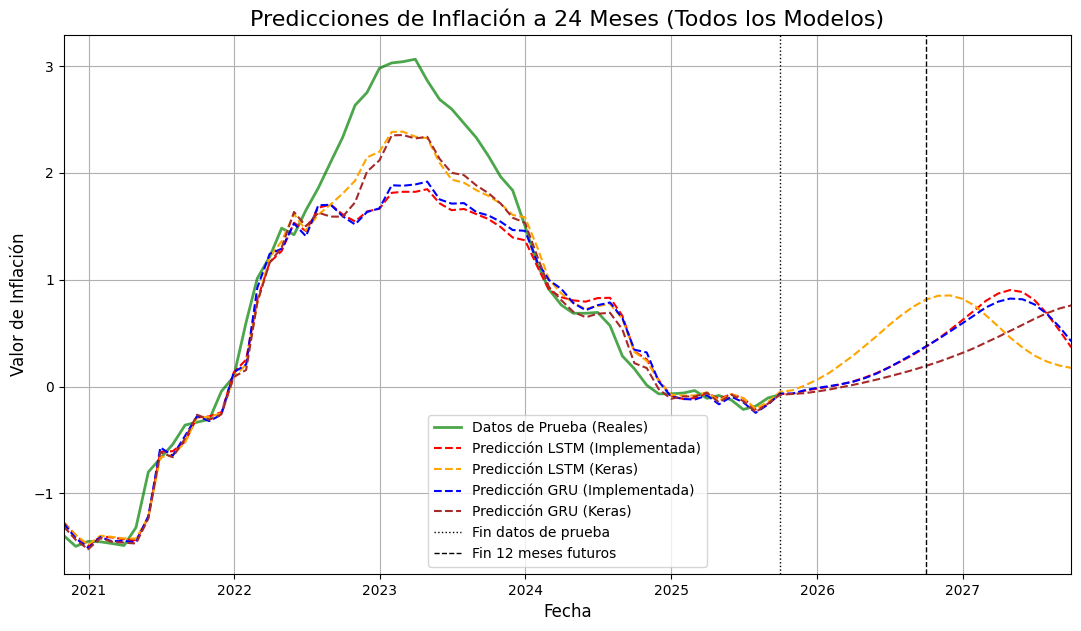

In [77]:
y_train_actual = scaler.inverse_transform(y_train_keras.reshape(-1, 1))
start_train_index = n_steps_in
end_train_index = start_train_index + train_size
train_dates = data.index[start_train_index:end_train_index]
start_test_index = end_train_index
end_test_index = start_test_index + len(y_test_keras)
test_dates = data.index[start_test_index:end_test_index]
combined_prediction_dates = pd.date_range(start=test_dates[0], periods=len(y_test_keras) + 24, freq='ME')
plt.figure(figsize=(13, 7))
plt.plot(test_dates, y_test_actual, label='Datos de Prueba (Reales)', color='green',linewidth=2, alpha=0.7)
plt.plot(combined_prediction_dates, combined_LSTM_predictions.flatten(), label='Predicción LSTM (Implementada)', color='red', linestyle='--')
plt.plot(combined_prediction_dates, combined_LSTM_keras_predictions.flatten(), label='Predicción LSTM (Keras)', color='orange', linestyle='--')
plt.plot(combined_prediction_dates, combined_GRU_predictions.flatten(), label='Predicción GRU (Implementada)', color='blue', linestyle='--')
plt.plot(combined_prediction_dates, combined_GRU_keras_predictions.flatten(), label='Predicción GRU (Keras)', color='brown', linestyle='--')
plt.axvline(x=test_dates[-1], color='black', linestyle=':', linewidth=1, label='Fin datos de prueba')
plt.axvline(x=combined_prediction_dates[len(y_test_keras) + 11], color='black', linestyle='--', linewidth=1, label='Fin 12 meses futuros')
plt.xlim(test_dates[0], combined_prediction_dates[-1])
plt.title('Predicciones de Inflación a 24 Meses (Todos los Modelos)', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Valor de Inflación', fontsize=12)
plt.legend()
plt.grid(True)

#plt.savefig("predicciones3.png")
plt.show()


<a name="6"></a>
## Predicción en intervalos de confianza (Opcional)


### Calcular Residuos del Conjunto de Prueba



In [ ]:
residuals_lstm = y_test_actual - y_pred_test_lstm_actual
residuals_gru = y_test_actual - y_pred_test_gru_actual

print("Residuals for implemented LSTM model:\n", residuals_lstm[:5])
print("\nResiduals for implemented GRU model:\n", residuals_gru[:5])

Residuals for implemented LSTM model:
 [[-0.00322957]
 [-0.00271117]
 [ 0.00112582]
 [-0.00128766]
 [-0.00147608]]

Residuals for implemented GRU model:
 [[-0.00296567]
 [-0.00194268]
 [ 0.00157095]
 [-0.00115541]
 [-0.00054922]]


In [ ]:
import copy

def bootstrap_prediction_intervals(model, parameters, scaler, last_window, n_steps_in, n_steps_out, residuals, n_bootstrap_samples=100, model_type='lstm'):
    """
    Genera predicciones futuras con intervalos de confianza utilizando un método de bootstrap.

    Argumentos:
    model -- La función de predicción del modelo (e.g., predict_lstm o predict_gru).
    parameters -- Diccionario con los parámetros entrenados del modelo.
    scaler -- El objeto StandardScaler utilizado para normalizar los datos.
    last_window -- La última ventana de datos escalados para iniciar la predicción, shape (1, 1, n_steps_in).
    n_steps_in -- Número de pasos de entrada de la ventana (para el reshape).
    n_steps_out -- Número de pasos a predecir (horizonte de predicción).
    residuals -- Residuos del conjunto de prueba (diferencia entre real y predicho), shape (num_residuals, 1).
    n_bootstrap_samples -- Número de muestras de bootstrap a generar.
    model_type -- Tipo de modelo ('lstm' o 'gru') para seleccionar la función de predicción.

    Retorna:
    mean_predictions -- La predicción media desnormalizada para cada paso futuro, shape (n_steps_out, 1).
    lower_bound -- El límite inferior del intervalo de confianza desnormalizado, shape (n_steps_out, 1).
    upper_bound -- El límite superior del intervalo de confianza desnormalizado, shape (n_steps_out, 1).
    """

    all_bootstrap_predictions_scaled = []
    residuals_flat = residuals.flatten()

    for _ in range(n_bootstrap_samples):
        current_window_bootstrap = copy.deepcopy(last_window)
        current_bootstrap_predictions_scaled = []

        for _ in range(n_steps_out):
            # Hacer la predicción base (escalada)
            if model_type == 'lstm':
                next_step_pred_scaled = predict_lstm(current_window_bootstrap, parameters)
            elif model_type == 'gru':
                next_step_pred_scaled = predict_gru(current_window_bootstrap, parameters)
            else:
                raise ValueError("model_type must be 'lstm' or 'gru'")

            # Seleccionar un residuo aleatorio con reemplazo
            random_residual = np.random.choice(residuals_flat)

            # Ajustar la predicción con el residuo
            adjusted_pred_scaled = next_step_pred_scaled.flatten()[0] + random_residual

            current_bootstrap_predictions_scaled.append(adjusted_pred_scaled)

            # Actualizar la ventana para la siguiente predicción
            # Asegurarse de que el new_window_values tenga la forma correcta antes de reshape
            new_window_values = np.append(current_window_bootstrap.flatten()[1:], adjusted_pred_scaled)
            current_window_bootstrap = new_window_values.reshape(1, 1, n_steps_in)

        all_bootstrap_predictions_scaled.append(current_bootstrap_predictions_scaled)

    # Convertir la lista de predicciones bootstrap a un array numpy
    all_bootstrap_predictions_scaled = np.array(all_bootstrap_predictions_scaled)

    # Calcular la media y los percentiles para cada paso de tiempo
    mean_predictions_scaled = np.mean(all_bootstrap_predictions_scaled, axis=0).reshape(-1, 1)
    lower_bound_scaled = np.percentile(all_bootstrap_predictions_scaled, 2.5, axis=0).reshape(-1, 1)
    upper_bound_scaled = np.percentile(all_bootstrap_predictions_scaled, 97.5, axis=0).reshape(-1, 1)

    # Desnormalizar las predicciones
    mean_predictions = scaler.inverse_transform(mean_predictions_scaled)
    lower_bound = scaler.inverse_transform(lower_bound_scaled)
    upper_bound = scaler.inverse_transform(upper_bound_scaled)

    return mean_predictions, lower_bound, upper_bound

print("bootstrap_prediction_intervals function defined.")

bootstrap_prediction_intervals function defined.


### Generar Intervalos de Predicción LSTM



In [ ]:
last_window_lstm = X_test[:, -1:, :]

lstm_mean_predictions, lstm_lower_bound, lstm_upper_bound = bootstrap_prediction_intervals(
    model=predict_lstm,
    parameters=modeloLSTM,
    scaler=scaler,
    last_window=last_window_lstm,
    n_steps_in=n_steps_in,
    n_steps_out=24,
    residuals=residuals_lstm,
    n_bootstrap_samples=500,
    model_type='lstm'
)

print("LSTM Mean Predictions (next 24 months):")
print(lstm_mean_predictions.flatten()[:5], "...")
print("\nLSTM Lower Bound (next 24 months):")
print(lstm_lower_bound.flatten()[:5], "...")
print("\nLSTM Upper Bound (next 24 months):")
print(lstm_upper_bound.flatten()[:5], "...")

LSTM Mean Predictions (next 24 months):
[0.05216888 0.05312047 0.05385947 0.05458962 0.05539937] ...

LSTM Lower Bound (next 24 months):
[0.05181743 0.05248596 0.05293874 0.05335824 0.05388316] ...

LSTM Upper Bound (next 24 months):
[0.05285222 0.05430982 0.05535578 0.05643293 0.05761728] ...


### Generar Intervalos de Predicción GRU


In [ ]:
last_window_gru = X_test[:, -1:, :]

gru_mean_predictions, gru_lower_bound, gru_upper_bound = bootstrap_prediction_intervals(
    model=predict_gru,
    parameters=modeloGRU,
    scaler=scaler,
    last_window=last_window_gru,
    n_steps_in=n_steps_in,
    n_steps_out=24,
    residuals=residuals_gru,
    n_bootstrap_samples=500,
    model_type='gru'
)

print("GRU Mean Predictions (next 24 months):")
print(gru_mean_predictions.flatten()[:5], "...")
print("\nGRU Lower Bound (next 24 months):")
print(gru_lower_bound.flatten()[:5], "...")
print("\nGRU Upper Bound (next 24 months):")
print(gru_upper_bound.flatten()[:5], "...")

GRU Mean Predictions (next 24 months):
[0.05223385 0.05322805 0.05404488 0.05478157 0.05551431] ...

GRU Lower Bound (next 24 months):
[0.05186666 0.05259803 0.05307471 0.05351404 0.05394228] ...

GRU Upper Bound (next 24 months):
[0.05286541 0.05435167 0.05550025 0.05651334 0.05753435] ...


### Graficar Predicciones LSTM con Intervalos


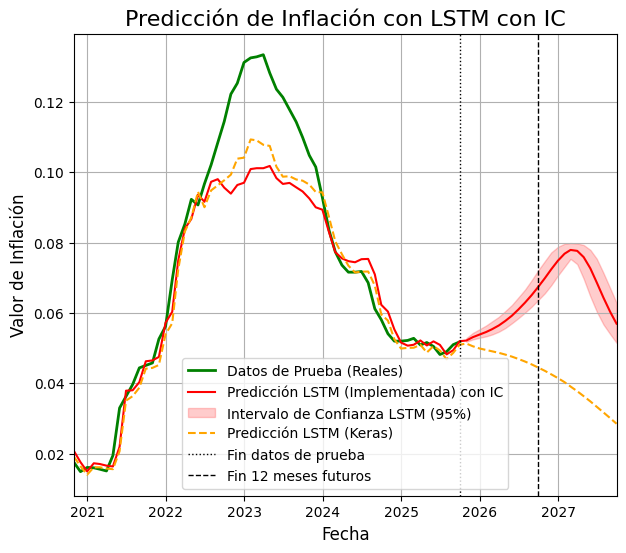

In [ ]:
import matplotlib.pyplot as plt

# Des-normalizar los datos para la gráfica
y_train_actual = scaler.inverse_transform(y_train_keras.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test_keras.reshape(-1, 1))
start_train_index = n_steps_in
end_train_index = start_train_index + train_size
train_dates = data.index[start_train_index:end_train_index]

start_test_index = end_train_index
end_test_index = start_test_index + len(y_test_keras)
test_dates = data.index[start_test_index:end_test_index]
combined_prediction_dates = pd.date_range(start=test_dates[0], periods=len(y_test_keras) + 24, freq='ME')
combined_lstm_bootstrap_mean_predictions = np.concatenate((y_pred_test_lstm_actual, lstm_mean_predictions))
plt.figure(figsize=(7, 6))
plt.plot(test_dates, y_test_actual, label='Datos de Prueba (Reales)', color='green', linewidth=2)
plt.plot(combined_prediction_dates, combined_lstm_bootstrap_mean_predictions.flatten(), label='Predicción LSTM (Implementada) con IC', color='red', linestyle='-')
future_dates_only = pd.date_range(start=test_dates[-1], periods=25, freq='ME')[1:]
plt.fill_between(future_dates_only, lstm_lower_bound.flatten(), lstm_upper_bound.flatten(), color='red', alpha=0.2, label='Intervalo de Confianza LSTM (95%)')
plt.plot(combined_prediction_dates, combined_LSTM_keras_predictions.flatten(), label='Predicción LSTM (Keras)', color='orange', linestyle='--')
plt.axvline(x=test_dates[-1], color='black', linestyle=':', linewidth=1, label='Fin datos de prueba')
plt.axvline(x=combined_prediction_dates[len(y_test_keras) + 11], color='black', linestyle='--', linewidth=1, label='Fin 12 meses futuros')
plt.xlim(test_dates[0], combined_prediction_dates[-1])
plt.title('Predicción de Inflación con LSTM con IC', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Valor de Inflación', fontsize=12)
plt.legend()
plt.grid(True)
#plt.savefig("lstmIC.png")
plt.show()

### Graficar Predicciones GRU con Intervalos


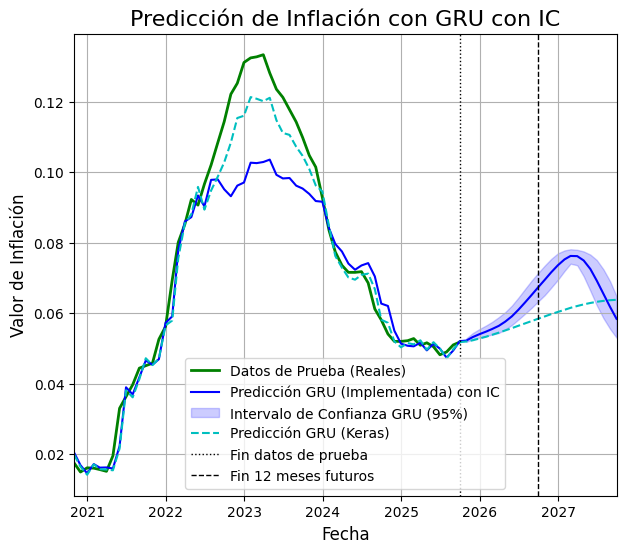

In [ ]:
# Des-normalizar los datos para la gráfica
y_train_actual = scaler.inverse_transform(y_train_keras.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test_keras.reshape(-1, 1))

# Crea un índice de fechas para la gráfica
start_train_index = n_steps_in
end_train_index = start_train_index + train_size
train_dates = data.index[start_train_index:end_train_index]

start_test_index = end_train_index
end_test_index = start_test_index + len(y_test_keras)
test_dates = data.index[start_test_index:end_test_index]

# Crear fechas futuras para las predicciones
future_dates_only = pd.date_range(start=test_dates[-1], periods=25, freq='ME')[1:]
combined_prediction_dates = pd.date_range(start=test_dates[0], periods=len(y_test_keras) + 24, freq='ME')
combined_gru_bootstrap_mean_predictions = np.concatenate((y_pred_test_gru_actual, gru_mean_predictions))
plt.figure(figsize=(7, 6))
plt.plot(test_dates, y_test_actual, label='Datos de Prueba (Reales)', color='green', linewidth=2)
plt.plot(combined_prediction_dates, combined_gru_bootstrap_mean_predictions.flatten(), label='Predicción GRU (Implementada) con IC', color='blue', linestyle='-')
plt.fill_between(future_dates_only, gru_lower_bound.flatten(), gru_upper_bound.flatten(), color='blue', alpha=0.2, label='Intervalo de Confianza GRU (95%)')
plt.plot(combined_prediction_dates, combined_GRU_keras_predictions.flatten(), label='Predicción GRU (Keras)', color='c', linestyle='--')
plt.axvline(x=test_dates[-1], color='black', linestyle=':', linewidth=1, label='Fin datos de prueba')
plt.axvline(x=combined_prediction_dates[len(y_test_keras) + 11], color='black', linestyle='--', linewidth=1, label='Fin 12 meses futuros')
plt.xlim(test_dates[0], combined_prediction_dates[-1])
plt.title('Predicción de Inflación con GRU con IC', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Valor de Inflación', fontsize=12)
plt.legend()
plt.grid(True)
#plt.savefig("gruIC.png")
plt.show()

<a name="7"></a>
## Bibliografia